# 5. Capstone Project: Exploratory Data Analysis I

***

![headerall](./images/headers/header_all.jpg)

### Project:
In this work, we will first analyze where and when traffic congestion is highest and lowest in New York State. We will then build different machine learning models capable of predicting cab travel times in and around New York City using only variables that can be easily obtained from a smartphone app or a website. We will then compare their performance and explore the possibility of using additional variables such as weather forecasts and holidays to improve the predictive performance of the models.

### Section:
In this section, we will detect and describe patterns, trends, and relationships among geospatial and temporal features in a subset (1%) of the 2018 NYC yellow cab trip dataset to identify variables that may impact traffic flow, and thus trip duration, in and around New York City.

The exploratory data analysis will be divided into two subsections, the first focused on the New York City taxi trip dataset (Exploratory Data Analysis, Part I), and the second on the external datasets (Data Preparation, Part II). At the end of the second subsection, the combined dataset will be analyzed.

## Data
### External Datasets:
- Weather Forecast: The 2018 NYC weather forecast was collected from the [National Weather Service Forecast Office](https://w2.weather.gov/climate/index.php?wfo=okx) website. Daily measurements were taken from January to December 2018 in Central Park. These measures are given in imperial units and include daily minimum and maximum temperatures, precipitations, snowfall, and snow depth.

- Holidays: The 2018 NYC holidays list was collected from the [Office Holiday](https://www.officeholidays.com/countries/usa/new-york/2021) website. The dataset contains the name, date, and type of holidays for New York.

- Taxi Zones: The NYC Taxi Zones dataset was collected from the [NYC Open Data](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) website. It contains the pickup and drop-off zones (Location IDs) for the Yellow, Green, and FHV Trip Records. The taxi zones are based on the NYC Department of City Planning’s Neighborhood.

### Primary Datasets:

- Taxi Trips: The 2018 NYC Taxi Trip dataset was collected from the [Google Big Query](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips?project=jovial-monument-300209&folder=&organizationId=) platform. The dataset contains more than 100'000'000 Yellow Taxi Trip records for 2018 and contains an extensive amount of variables including the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Table of Content:
    1. Data Preparation
        1.1 External Datasets
            1.1.1 Weather Forecast Dataset
            1.1.2 Holidays Dataset
            1.1.3 Taxi Zones Dataset
        1.2 Primary Dataset
            1.2.1 Taxi Trips Dataset
            1.2.2 Taxi Trips Subset
    2. Exploratory Data Analysis
        2.1 Primary Dataset
            2.1.1 Temporal Analysis
            2.1.2 Spatio-Temporal Analysis
        2.2 External Datasets
            2.2.1 Temporal Analysis of Weather Data
            2.2.2 Temporal Analysis of Holidays Data
        2.3 Combined Dataset
            2.3.1 Overall Features Correlation
    3. Machine Learning Models

***
## Python Libraries and Magic commands Import

In [1]:
# Import python core libraries
import itertools

# Import data processing libraries
import numpy as np
import pandas as pd

# Import Visualization librairies
import contextily as ctx
import seaborn as sns
import matplotlib.pyplot as plt

# Import machine learning libraries
from sklearn.model_selection import train_test_split

In [2]:
# Set up magic commands
%matplotlib inline
%config Completer.use_jedi = False

***
## Data Import

In [3]:
# Import the train dataset
train_df = pd.read_pickle(r'data/processed/train.pickle')

# Import the test dataset
test_df = pd.read_pickle(r'data/processed/test.pickle')

# Import the sub train dataset
train_sub_df = pd.read_pickle(r'data/processed/train_sub.pickle')

# Import the sub test dataset
test_sub_df = pd.read_pickle(r'data/processed/test_sub.pickle')

# Import the zones dataset
zones_df = pd.read_pickle(r'data/processed/zones.pickle')

***
## Variables Import

In [4]:
# List of boroughs
boroughs = ["EWR", "Queens", "Bronx", "Manhattan", "Staten Island", "Brooklyn"]

# List of week days
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

***
## Functions import

In [5]:
# Define a function that transform column headers to titles
def to_title(data, sep="_"):
    return [s.replace(sep, " ").title() for s in data]

In [6]:
# Define a function that display a correlation heatmap
def plot_corrmap(data, title="", figsize=(20, 20), palette="YlGnBu_r"):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    sns.heatmap(
        data,
        ax=ax,
        cmap=palette,
        annot=True,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)

    # Display the figure
    plt.show()

In [7]:
# Define a function that display a heatmap
def plot_heatmap(
    data,
    xticks,
    yticks,
    xlabel,
    ylabel,
    title="",
    xlim=0,
    figsize=(20, 5),
    palette="YlGnBu_r",
):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    sns.heatmap(data, ax=ax, xticklabels=xticks, yticklabels=yticks, cmap=palette)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), va="center")
    ax.set_yticklabels(ax.get_yticklabels(), va="center")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlim(xlim)
    ax.invert_yaxis()
    ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)
    
    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)

    # Display the figure
    plt.show()

In [8]:
# Define a function that display individual scatterplot
def plot_scatterplot(
    data,
    x_var,
    y_var,
    xlabel,
    ylabel,
    title="",
    labels=None,
    label_order=None,
    legend=None,
    figsize=(20, 5),
    palette="YlGnBu",
):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    if labels == None:
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, palette=palette)
    else:
        sns.scatterplot(
            x=x_var,
            y=y_var,
            hue=labels,
            hue_order=label_order,
            data=data,
            ax=ax,
            palette=palette,
        )
        ax.legend(title=legend)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_ticks_position("none")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xscale('log')
    ax.grid()
    
    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)
    
    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)

    # Display the figure
    plt.show()

In [9]:
# Define a function that display individual barplot
def plot_lineplot(
    data,
    x_var,
    y_var,
    xlabel,
    ylabel,
    title="",
    labels=None,
    label_order=None,
    legend=None,
    figsize=(20, 5),
    palette="YlGnBu",
    color="C0"
):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    if labels == None:
        sns.lineplot(
            x=x_var,
            y=y_var,
            data=data,
            ax=ax,
            color=color,
        )
    else:
        sns.lineplot(
            x=x_var,
            y=y_var,
            hue=labels,
            hue_order=label_order,
            data=data,
            ax=ax,
            palette=palette,
        )
        ax.legend(title=legend)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_ticks_position("none")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)
    
    # Display the figure
    plt.show()

In [10]:
# Define a function that display individual barplot
def plot_barplot(
    data,
    x_var,
    y_var,
    xlabel,
    ylabel,
    title="",
    labels=None,
    label_order=None,
    legend=None,
    figsize=(20, 5),
    palette="YlGnBu",
):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    if labels == None:
        sns.barplot(
            x=x_var,
            y=y_var,
            data=data,
            ax=ax,
            palette=palette,
        )
    else:
        sns.barplot(
            x=x_var,
            y=y_var,
            hue=labels,
            hue_order=label_order,
            data=data,
            ax=ax,
            palette=palette,
        )
        ax.legend(title=legend)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_ticks_position("none")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)
    
    # Display the figure
    plt.show()

In [11]:
# Define a function that display individual barplot
def plot_boxplot(
    data,
    x_var,
    y_var,
    xlabel,
    ylabel,
    title="",
    figsize=(20, 5),
    palette="YlGnBu",
):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    sns.boxplot(
        x=x_var,
        y=y_var,
        data=data,
        ax=ax,
        width=0.5,
        linewidth=0.75,
        palette=palette,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_ticks_position("none")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)
    
    # Display the figure
    plt.show()

In [12]:
def plot_clockhist(
    data,
    columns,
    colnames,
    title,
    ylim,
    yticks,
    yticklabels,
    nrows=1,
    ncols=1,
    palette="YlGnBu",
):

    # Get the color palette
    cpal = itertools.cycle(sns.color_palette(palette, len(columns)))

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(5 * ncols, 5 * nrows),
        subplot_kw=dict(projection="polar"),
    )

    # Flatten axes for 2D figures
    if ncols > 1 and nrows > 1:
        axes = axes.ravel()

    # Disable all axes
    for ax in axes:
        ax.set_axis_off()

    # Define theta for 24 hours
    theta = np.linspace(0, 2 * np.pi, 24, endpoint=False)

    # Define the width of each bin
    width = np.divide(np.multiply(2, np.pi), 24)

    # Generate the plots
    for ax, col, colname, color in zip(axes, columns, colnames, cpal):
        ax.bar(
            theta,
            data[col],
            width=width,
            align="edge",
            linewidth=0.25,
            color=color,
            edgecolor="dimgrey",
        )
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location("N")
        ax.set_ylim(0, ylim)
        ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
        ax.set_yticks(yticks)
        ax.set_xticklabels(
            [f"{x}:00" for x in np.arange(0, 24, 3)],
            rotation="vertical",
            fontsize=12,
        )
        ax.set_yticklabels(
            yticklabels, rotation="vertical", fontsize=12
        )
        ax.set_title(colname, fontsize=16)
        ax.set_axis_on()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=1, w_pad=1)

    # Adding a title to the plot
    plt.suptitle(title.title(), y=1.10, fontsize=18)

    # Display the plot
    plt.show()

In [13]:
def plot_map(
    data,
    columns,
    colnames,
    nrows=1,
    ncols=1,
    legend=True,
    figsize=(20, 5),
    palette="YlGnBu_r",
):
    # Creat a figure with n rows and one columns
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        constrained_layout=True,
        sharex=True,
        sharey=True,
        subplot_kw=dict(aspect="equal"),
    )

    # Get the min from selected columns in the data frame
    vmin = np.min([data[c].min() for c in columns])

    # Get the max from selected columns in the data frame
    vmax = np.max([data[c].max() for c in columns])

    # Flatten axes for 2D figures
    if ncols > 1 and nrows > 1:
        axes = axes.ravel()

    # Disable all axes
    for ax in axes:
        ax.set_axis_off()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        plot = data.plot(
            column=col,
            ax=ax,
            alpha=0.33,
            cmap=sns.color_palette(palette, as_cmap=True),
            edgecolor="k",
            linewidth=0.33,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_title(colname.title(), fontsize=18, pad=15)

        # Add a base map of New York City
        ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

    # assume it's the first (and only) mappable
    cb = fig.colorbar(
        axes[0].collections[0],
        ax=axes,
        shrink=0.5,
        orientation="horizontal",
    )

    # Display the plot
    plt.show()

***
## 2.1 Exploratory Data Analysis: Primary Dataset

## 2.1.1 Primary Dataset: Temporal Analysis
### Goal:
Detect and describe patterns, trends, and relationships among temporal features in a subset (1%) of the 2018 NYC yellow cab trip dataset to identify variables that may impact traffic flow, and thus trip duration, in and around New York City.
### Code:

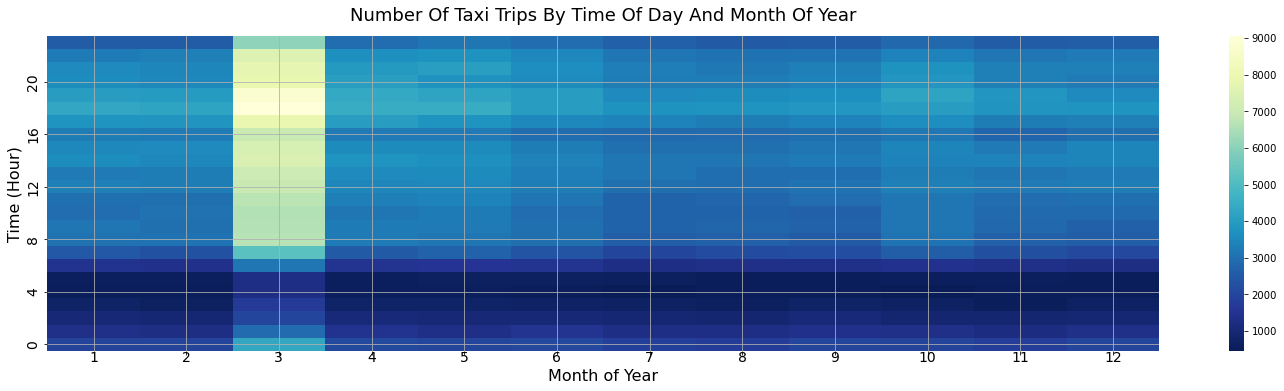

In [14]:
# Group taxi trips by pickup month of year and hour of day
# Compute the number of taxi trips
monthly_rides = (
    train_df.groupby(["pickup_month", "pickup_hour"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Pivot the data frame on the pickup month column
monthly_rides_pvt = monthly_rides.pivot(
    index="pickup_hour", columns="pickup_month", values="count"
)

# Display a heatmap of taxi trips by month of year and day time
plot_heatmap(
    monthly_rides_pvt,
    xticks=1,
    yticks=4,
    xlabel="Month of Year",
    ylabel="Time (Hour)",
    title="number of taxi trips by time of day and month of year"
)

**Notes:** The heat map above shows the number of taxi trips by month and time. The largest increase in the number of trips is observed in March, while the months of July through September, and November through December show a slight decrease compared to the rest of the year. Looking at the hourly scale, we observe that the number of hourly runs starts to decrease rapidly after midnight and increases again around 18:00. The largest daily increase is reached around 19:00. 

**Warnings:** The number of taxi trips is corresponds to 0.8% of the whole dataset.

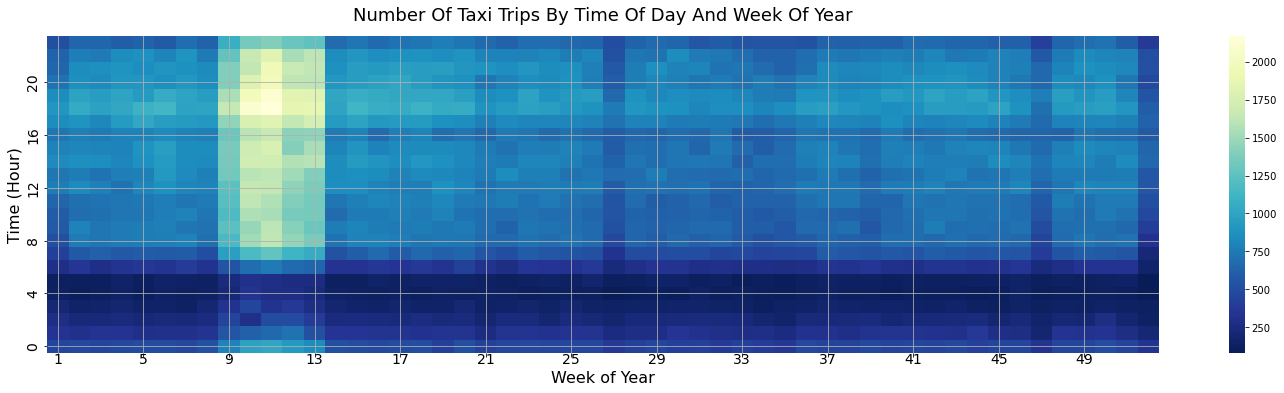

In [15]:
# Group taxi trips by pickup week of year and hour of day
# Compute the number of taxi trips
weekly_rides = (
    train_df.groupby(["pickup_week", "pickup_hour"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Pivot the data frame on the pickup week column
weekly_rides_pvt = weekly_rides.pivot(
    index="pickup_hour", columns="pickup_week", values="count"
)

# Display a heatmap of taxi trips by week of year and time
plot_heatmap(
    weekly_rides_pvt,
    xticks=4,
    yticks=4,
    xlabel="Week of Year",
    ylabel="Time (Hour)",
    title="number of taxi trips by time of day and week of year"
)

**Notes:** The heat map above shows the number of taxi trips by week and time. As previously noted, the largest increase in trips is seen in March and specifically from week 9 to week 13. This increase coincides with the start and end of spring break - a national school vacation whose start and end date depends on the state, but which typically begins in late February and ends in late March. The week following the national holiday of July 14 (week 27), the week of Thanksgiving (week 47), and New Year's Eve (week 53) may also account for some of the slight declines observed in July, November, and December 2018. 

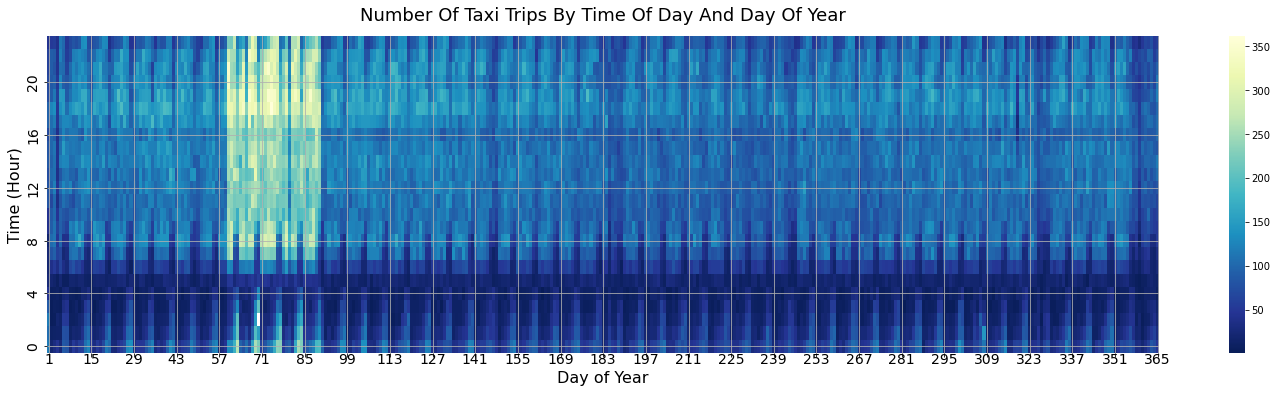

In [16]:
# Group taxi trips by pickup day of year and hour of day
# Compute the number of taxi trips
daily_rides = (
    train_df.groupby(["pickup_yearday", "pickup_hour"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Pivot the data frame on the pickup year day column
daily_rides_pvt = daily_rides.pivot(
    index="pickup_hour", columns="pickup_yearday", values="count"
)

# Display a heatmap of taxi trips by day of year and time
plot_heatmap(
    daily_rides_pvt,
    xticks=14,
    yticks=4,
    xlabel="Day of Year",
    ylabel="Time (Hour)",
    title="number of taxi trips by time of day and day of year",
)

**Notes:** The heat map above shows the number of taxi trips by day and hour. Examination of the data at the daily and hourly scales reveals two different patterns: on weekdays, the number of hourly trips begins to decline rapidly after midnight and increases again around 6:00 a.m., while on weekends, taxi trips remain high until 16:00 and decline significantly between 5:00 and 8:00. On weekdays, the largest daily increase is reached around 19:00, while on weekends the number of trips is relatively stable throughout the day and until late at night.

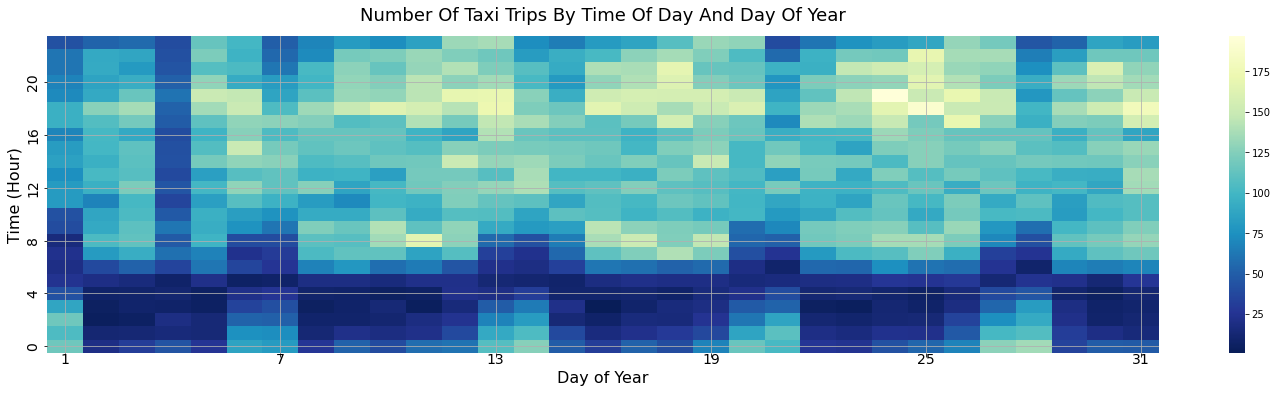

In [17]:
# Display a heatmap of taxi trips by day of year and time for first 31 days of the year
plot_heatmap(
    daily_rides_pvt.iloc[:, 0:31],
    xticks=6,
    yticks=4,
    xlabel="Day of Year",
    ylabel="Time (Hour)",
    title="number of taxi trips by time of day and day of year",
)

**Notes:** The heat map above shows the number of taxi trips by day and hour for the first 31 days of the year. The number of rides appears to drop sharply from Saturday to Sunday. In addition, on January 4, 2018, New York City was hit hard by a powerful cyclonic blizzard, which caused many disruptions.

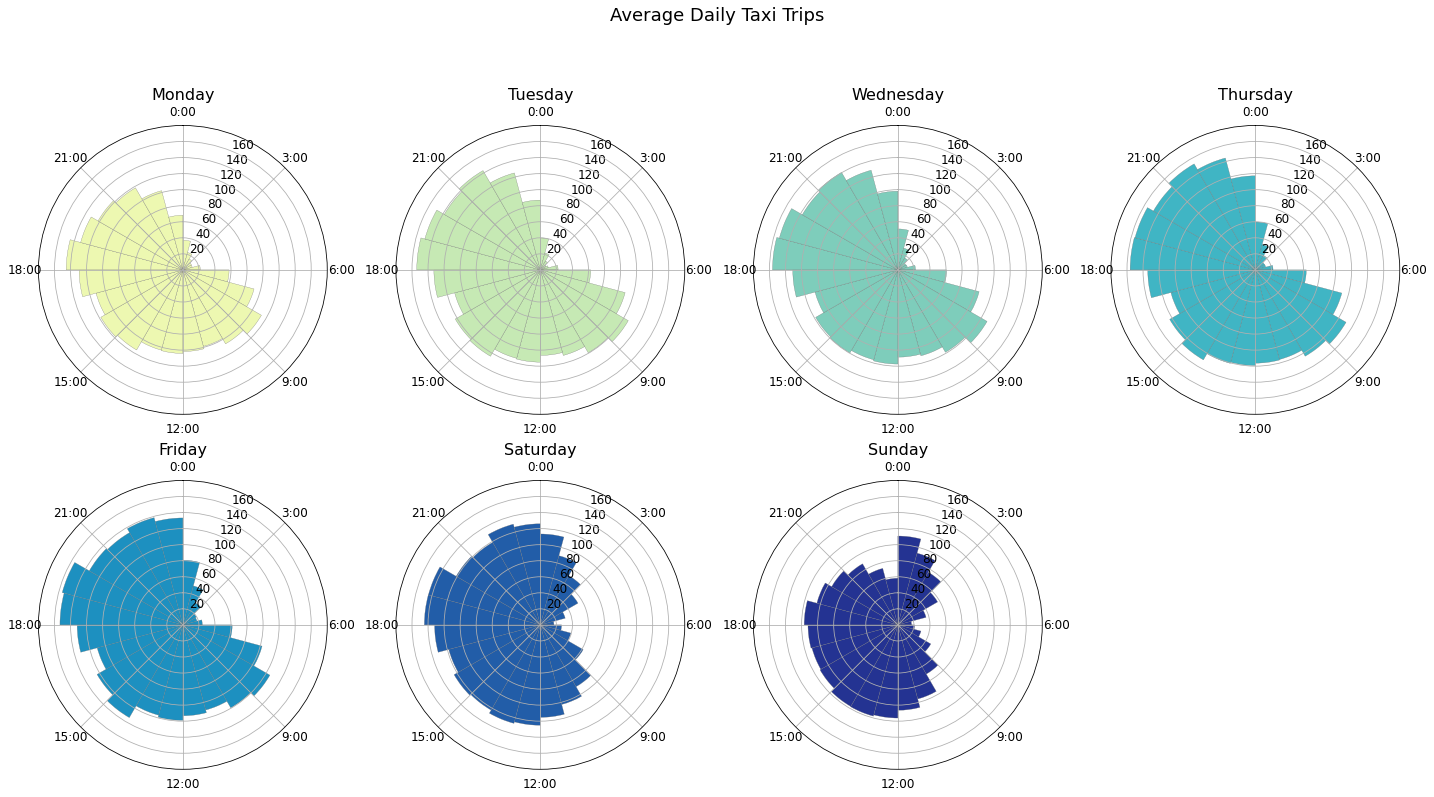

In [18]:
# Group taxi trips by pickup year day, week day, and hour of day
# Compute the number of daily trip
hourly_pickup_count = (
    train_df.groupby(["pickup_yearday", "pickup_weekday", "pickup_hour"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Group taxi trips by pickup weekday, and hour of day
# Compute the average number of daily trips
hourly_pickup_count = (
    hourly_pickup_count.groupby(["pickup_weekday", "pickup_hour"])
    .agg({"count": np.mean})
    .reset_index()
)

# Map numerical values to week days
hourly_pickup_count["pickup_weekday"] = hourly_pickup_count["pickup_weekday"].map(
    dict(zip(np.arange(0, 7), [w.lower() for w in weekdays]))
)

# Pivot the data frame on the pickup week day column
hourly_pickup_count_pvt = hourly_pickup_count.pivot(
    index="pickup_hour", columns="pickup_weekday", values="count"
)


# Display circular barplots of the average daily taxi trip per hour and for each day of the week
plot_clockhist(
    hourly_pickup_count_pvt,
    columns=[w.lower() for w in weekdays],
    colnames=weekdays,
    title="Average daily taxi trips",
    ylim=180,
    yticks=np.arange(20, 180, 20),
    yticklabels=[f"{y}" for y in np.arange(20, 180, 20)],
    ncols=4,
    nrows=2,
)

**Notes:** The circular barplots above shows the average number of daily taxi trips for every day of the week. Similar trends are observed from Monday to Friday, but the number of taxi trips increases throughout the week, especially from 6:00 pm to 1:00 am. On Sunday, the number of taxi trips remains stable throughout the day, with a peak between 00:00 and 01:00. New Yorkers tend to go out on weekends, but less frequently on weekdays. In addition, people seem to take cabs less on Sundays during the day, but continue to go out after midnight.

**Warnings:** The average number of taxi trips is computed on 0.8% of the whole dataset.

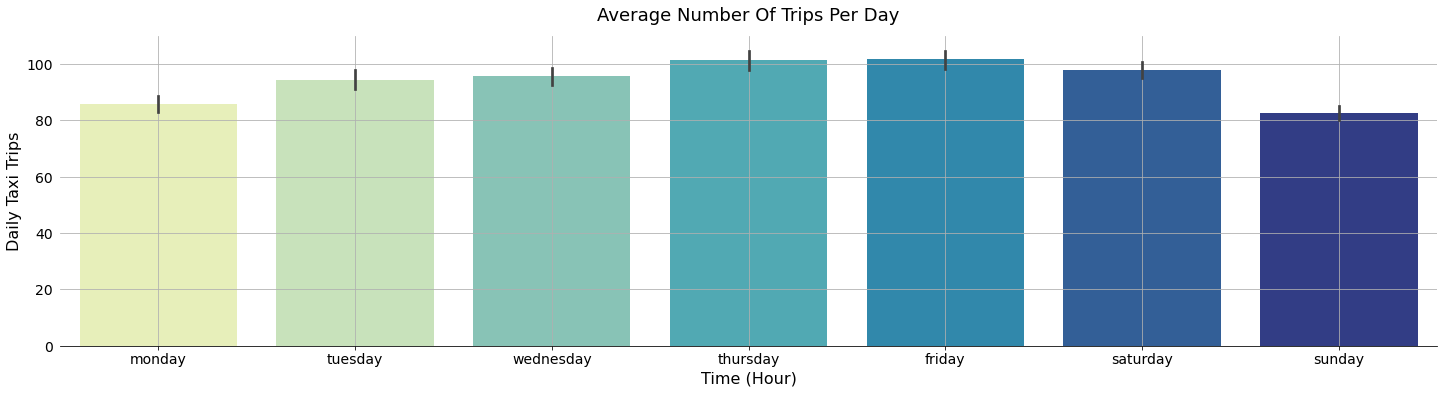

In [19]:
# Group taxi trips by pickup year day, week day, and hour of day
# Compute the number of daily trip
hourly_pickup_count = (
    train_df.groupby(["pickup_yearday", "pickup_weekday", "pickup_hour"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Replace zero counts with NaN to avoid impacting the mean
hourly_pickup_count["count"].replace(0, np.nan, inplace=True)

# Map numerical values to week days
hourly_pickup_count["pickup_weekday"] = hourly_pickup_count["pickup_weekday"].map(
    dict(zip(np.arange(0, 7), [w.lower() for w in weekdays]))
)

# Display a barplot of the average number of daily taxi trip
plot_barplot(
    hourly_pickup_count,
    x_var="pickup_weekday",
    y_var="count",
    xlabel="Time (Hour)",
    ylabel="Daily Taxi Trips",
    title="average number of trips per day"
)

**Notes:** The barplot above shows the average number of trips per day. As noted earlier, the average number of taxi trips increases from Monday to Friday and then decreases again on weekends, with the largest decrease on Sunday. The closing of offices on weekends may explain the decline in taxi trips on Saturday and Sunday. However, the gradual increase in daily trips from Monday to Friday is more difficult to explain. One hypothesis could be that bars and restaurants open on weekends, close on Mondays.

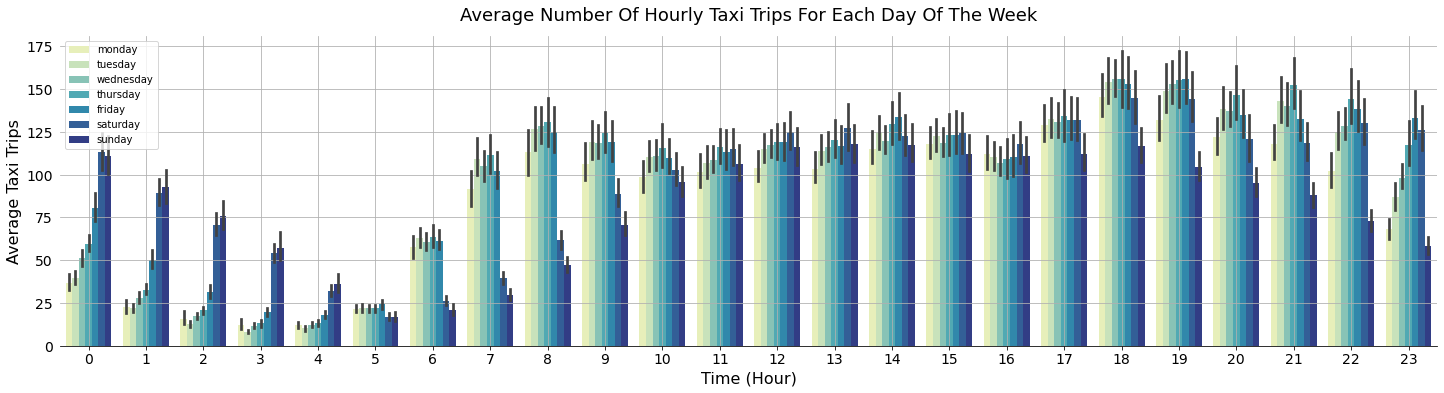

In [20]:
# Display a barplot of the average number of hourly taxi trip for all week days
plot_barplot(
    hourly_pickup_count,
    x_var="pickup_hour",
    y_var="count",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average Taxi Trips",
    title="average number of hourly taxi trips for each day of the week",
)

**Notes:** The barplot above shows the average number of hourly taxi trips for each day of the week. It appears that the average number of hourly trips can vary significantly throughout the year, especially during peak hours, which begin at 06:00 and end around 21:00. Moreover, the number of trips is not necessarily correlated with traffic fluidity and congestion and thus with trip duration - the variable we are trying to predict. Below we look at the average length, duration and speed of trips on a monthly, daily and hourly scale. Trip speed will be used as an indicator of traffic fluidity/congestion. But before we do, let's first repeat this analysis for one of the most common trips in Manhattan.

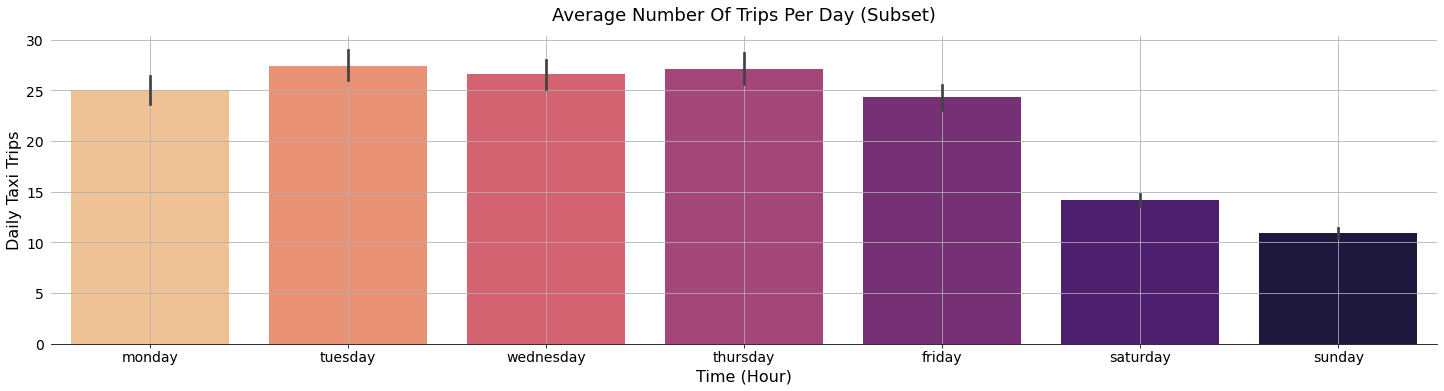

In [21]:
# Group taxi trips by pickup year day, week day, and hour of day
# Compute the number of daily trip
hourly_pickup_count_sub = (
    train_sub_df.groupby(["pickup_yearday", "pickup_weekday", "pickup_hour"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Replace zero counts with NaN to avoid impacting the mean
hourly_pickup_count_sub["count"].replace(0, np.nan, inplace=True)

# Map numerical values to week days
hourly_pickup_count_sub["pickup_weekday"] = hourly_pickup_count_sub[
    "pickup_weekday"
].map(dict(zip(np.arange(0, 7), [w.lower() for w in weekdays])))

# Display a barplot of the average number of daily taxi trip
plot_barplot(
    hourly_pickup_count_sub,
    x_var="pickup_weekday",
    y_var="count",
    xlabel="Time (Hour)",
    ylabel="Daily Taxi Trips",
    title="average number of trips per day (subset)",
    palette="magma_r",
)

**Notes:** the barplot above shows the average number of trips per day. The average number of taxi trips increases from Monday through Thursday, then decreases from Friday onward and over the weekend, with the largest decrease on Saturday. As a reminder, this subset contains only trips between two neighborhoods located within Manhattan's central business district. These observations thus support the hypothesis stated earlier that weekend office closures may explain, at least partially, the decline in cab trips on Saturday and Sunday.

**Warnings:** The average number of taxi trips is computed on 80% of the whole dataset.

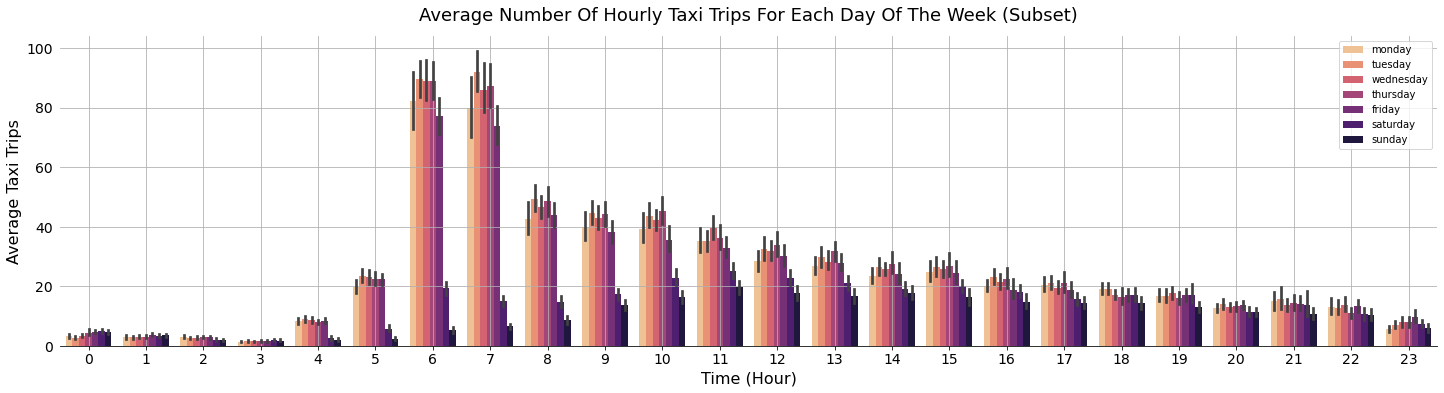

In [22]:
# Display a barplot of the average number of hourly taxi trip for all week days
plot_barplot(
    hourly_pickup_count_sub,
    x_var="pickup_hour",
    y_var="count",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average Taxi Trips",
    title="average number of hourly taxi trips for each day of the week (Subset)",
    palette="magma_r"
)

**Notes:** The barplot above shows the average number of hourly taxi trips for each day of the week. The average number of hourly trips can vary significantly throughout the year, especially early in the morning between 06:00 and 07:00. Trips between Penn Station/Madison sq West and Midtown Center appear to be particularly frequent early in the morning between 06:00 and 07:00, while these trips become less frequent from the afternoon onward and during the weekend. This may indicate that this itinerary is primarily used by commuters to get to work.

In [ ]:
# Group taxi trips by pickup year day, month of year, week day, and hour of day
# Compute the mean of trip distances and durations
hourly_pickup_avg = (
    train_df.groupby(["pickup_yearday", "pickup_month", "pickup_weekday", "pickup_hour"])
    .agg({"trip_distance": np.mean, "trip_duration": np.mean})
    .reset_index()
)

# Compute the average trip speed
hourly_pickup_avg["trip_speed"] = np.divide(
    hourly_pickup_avg["trip_distance"],
    np.divide(hourly_pickup_avg["trip_duration"], 60),
)

# Map numerical values to week days
hourly_pickup_avg["pickup_weekday"] = hourly_pickup_avg["pickup_weekday"].map(
    dict(zip(np.arange(0, 7), [w.lower() for w in weekdays]))
)

# Display descriptive statistics of selected columns
hourly_pickup_avg[["trip_distance", "trip_duration", "trip_speed"]].describe()

In [ ]:
# Display boxplots of average daily trip distance for each month of the year
plot_boxplot(
    hourly_pickup_avg,
    x_var="pickup_month",
    y_var="trip_distance",
    xlabel="Month of Year",
    ylabel="Average Distance (Km)",
    title="average daily trip distance for each month of the year"
)

**Notes:** the boxplot above shows the daily average distance traveled for each month of the year. The average trip distance shows no significant changes throughout 2018.

In [ ]:
# Display boxplots of average daily trip duration for each month of the year
plot_boxplot(
    hourly_pickup_avg,
    x_var="pickup_month",
    y_var="trip_duration",
    xlabel="Month of Year",
    ylabel="Average Duration (Min)",
    title="average daily trip duration for each month of the year"
)

**Notes:** the boxplot above shows the average daily travel time for each month of the year. The average trip duration shows no significant changes throughout 2018.

In [ ]:
# Display boxplots of average daily trip speed for each month of the year
plot_boxplot(
    hourly_pickup_avg,
    x_var="pickup_month",
    y_var="trip_speed",
    xlabel="Month of Year",
    ylabel="Average speed (Km/h)",
    title="average daily trip speed for each month of the year"
)

**Notes:** The barplot above shows the average daily travel speed for each month of the year. The average trip speed shows no significant changes throughout 2018. Below we will repeat this analysis for the taxi trip subset.

In [ ]:
# Group taxi trips by pickup year day, month of year, week day, and hour of day
# Compute the mean of trip distances and durations
hourly_pickup_avg_sub = (
    train_sub_df.groupby(["pickup_yearday", "pickup_month", "pickup_weekday", "pickup_hour"])
    .agg({"trip_distance": np.mean, "trip_duration": np.mean})
    .reset_index()
)

# Compute the average trip speed
hourly_pickup_avg_sub["trip_speed"] = np.divide(
    hourly_pickup_avg_sub["trip_distance"],
    np.divide(hourly_pickup_avg_sub["trip_duration"], 60),
)

# Map numerical values to week days
hourly_pickup_avg_sub["pickup_weekday"] = hourly_pickup_avg_sub["pickup_weekday"].map(
    dict(zip(np.arange(0, 7), [w.lower() for w in weekdays]))
)

# Display descriptive statistics of selected columns
hourly_pickup_avg_sub[["trip_distance", "trip_duration", "trip_speed"]].describe()

In [ ]:
# Display boxplots of average daily trip duration for each month of the year
plot_boxplot(
    hourly_pickup_avg_sub,
    x_var="pickup_month",
    y_var="trip_duration",
    xlabel="Month of Year",
    ylabel="Average Duration (Min)",
    palette="magma_r",
    title="average daily trip duration for each month of the year (subset)"
)

**Notes:** The barplot above shows the average daily travel time for each month of the year. In the taxi trips subset, the average trip duration also shows overall no significant changes throughout 2018. However, the distribution of average daily trip length widens throughout the year and more strongly in the middle and end of 2018.

In [ ]:
# Display boxplots of average daily trip speed for each month of the year
plot_boxplot(
    hourly_pickup_avg_sub,
    x_var="pickup_month",
    y_var="trip_speed",
    xlabel="Month of Year",
    ylabel="Average speed (Km/h)",
    palette="magma_r",
    title="average daily trip speed for each month of the year (subset)"
)

**Notes:** The barplot above shows the average daily travel speed for each month of the year. In the taxi trips subset, the average trip speed also shows no significant changes throughout 2018.

In [ ]:
# Display a line plot of average trip distance for each hour of the day and day of the week
plot_lineplot(
    hourly_pickup_avg,
    x_var="pickup_hour",
    y_var="trip_distance",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average Distance (Km)",
    title="average trip distance for each hour of the day and day of the week"
)

**Notes:** The line plot above shows the average daily distance traveled for each hour of the day and each day of the week. The average distance traveled is significantly lower between 00:00 and 02:00, and significantly higher between 05:00 and 08:00 on Saturdays and Sundays. This may suggest that New Yorkers do not travel to the same locations on weekdays and weekends. We will investigate this assumption at a later stage.

In [ ]:
# Display a line plot of average trip duration for each hour of the day and day of the week
plot_lineplot(
    hourly_pickup_avg,
    x_var="pickup_hour",
    y_var="trip_duration",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average Duration (Min)",
    title="average trip duration for each hour of the day and day of the week"
)

**Notes:** The line plot above shows the average daily travel time for each hour of the day and each day of the week. The average travel time is significantly lower on Saturdays and Sundays during peak hours. This may suggest that New Yorkers do not travel to the same places on weekdays and weekends. Another possible interpretation may corroborate our previous observations, namely that fewer taxi trips may be a good indicator of less traffic and potentially better traffic conditions.

In [ ]:
# Display a line plot of average trip speed for each hour of the day and day of the week
plot_lineplot(
    hourly_pickup_avg,
    x_var="pickup_hour",
    y_var="trip_speed",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average speed (Km/h)",
    title="average trip speed for each hour of the day and day of the week"
)

**Notes:** The line plot above shows the average daily travel speed for each hour of the day and each day of the week. As a result of higer distance travelled early morning and lower travel durations during rush hour, the average travel speed is significantly higher on the weekends between 06:00 and 11:00. Below we will repeat this analysis for the taxi trip subset.

In [ ]:
# Display a line plot of average trip duration for each hour of the day and day of the week
plot_lineplot(
    hourly_pickup_avg_sub,
    x_var="pickup_hour",
    y_var="trip_duration",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average Duration (Min)",
    palette="magma_r",
    title="average trip duration for each hour of the day and day of the week (subset)"
)

**Notes:** The line plot above shows the average daily travel time for each hour of the day and each day of the week. In the taxi trips subset, the average travel time between Penn Station/Madison sq West and Midtown Center is significantly lower on Saturdays and Sundays in the morning. These observation shows that fewer taxi trips may be a good indicator of lower traffic density and potentially better traffic conditions.

In [ ]:
# Display a line plot of average trip speed for each hour of the day and day of the week
plot_lineplot(
    hourly_pickup_avg_sub,
    x_var="pickup_hour",
    y_var="trip_speed",
    labels="pickup_weekday",
    xlabel="Time (Hour)",
    ylabel="Average speed (Km/h)",
    palette="magma_r",
    title="average trip speed for each hour of the day and day of the week (subset)"
)

**Notes:** The line plot above shows the average daily travel speed for each hour of the day and each day of the week. As a result of higer distance travelled early morning and lower travel durations during rush hour, the average travel speed is significantly higher on the weekends between 06:00 and 11:00.

In [ ]:
# Display a line plot of average daily trip distance for each day of the year
plot_lineplot(
    hourly_pickup_avg,
    x_var="pickup_yearday",
    y_var="trip_distance",
    xlabel="Time (Hour)",
    ylabel="Average Distance (Km)",
    title="average trip distance for each day of the year",
    color="#3999C1"
)

**Notes:** The line plot above shows the average daily distance traveled for each day of the year. The average distance traveled fluctuates throughout the year with repeated weekly spikes and drops. We can observe commuting patterns, but these patterns may vary by day, week, or month of the year.

In [ ]:
# Display a line plot of average daily trip duration for day of the year
plot_lineplot(
    hourly_pickup_avg,
    x_var="pickup_yearday",
    y_var="trip_duration",
    xlabel="Time (Hour)",
    ylabel="Average Duration (min)",
    title="average trip duration for day of the year",
    color="#3999C1"
)

**Notes:** The line plot above shows the average daily distance traveled for each day of the year. The average travel duration fluctuates throughout the year with repeated weekly peaks and drops. These peaks and drops appear to be most intense between late February and May and the end of the year.

In [ ]:
# Display a line plot of average daily trip speed for day of the year
plot_lineplot(
    hourly_pickup_avg,
    x_var="pickup_yearday",
    y_var="trip_speed",
    xlabel="Time (Hour)",
    ylabel="Average speed (Km/h)",
    title="average trip speed for day of the year",
    color="#3999C1"
)

**Notes:** The line plot above shows the average daily travel speed for each day of the year. The average travel speed fluctuates throughout the year with repeated weekly peaks and drops. In contrast to travel distance and time, travel speed appears to be more stable. However, more variations can be observed during the summer and at the end of the year. Different events

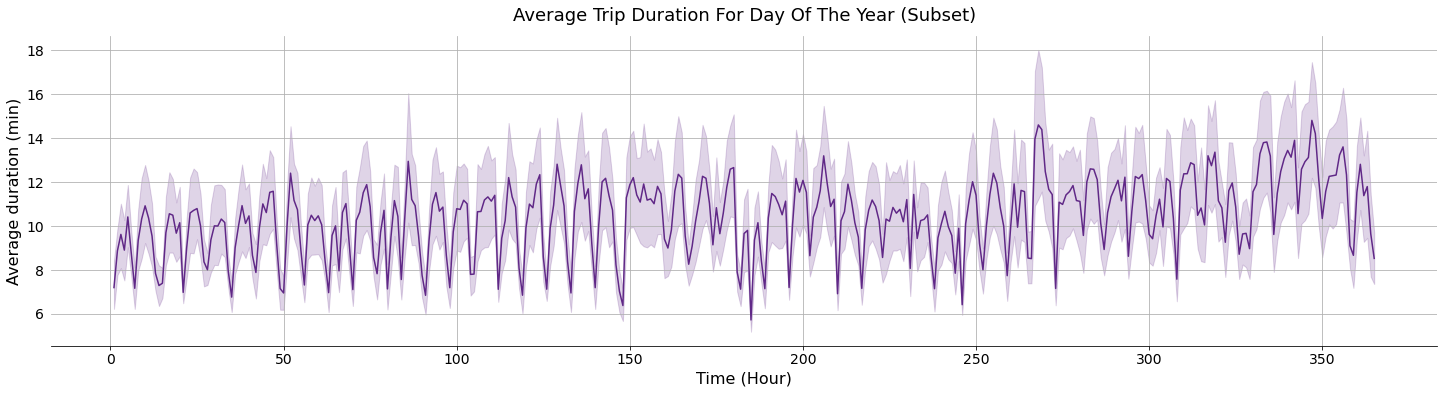

In [38]:
# Display a line plot of average daily trip duration for day of the year
plot_lineplot(
    hourly_pickup_avg_sub,
    x_var="pickup_yearday",
    y_var="trip_duration",
    xlabel="Time (Hour)",
    ylabel="Average duration (min)",
    title="average trip duration for day of the year (subset)",
    color="#602887"
)

**Notes:** The line plot above shows the average daily travel duration for each day of the year. The average distance duration fluctuates throughout the year with repeated weekly peaks and drops. These peaks and drops appear to be most intense between late February and May and the end of the year.

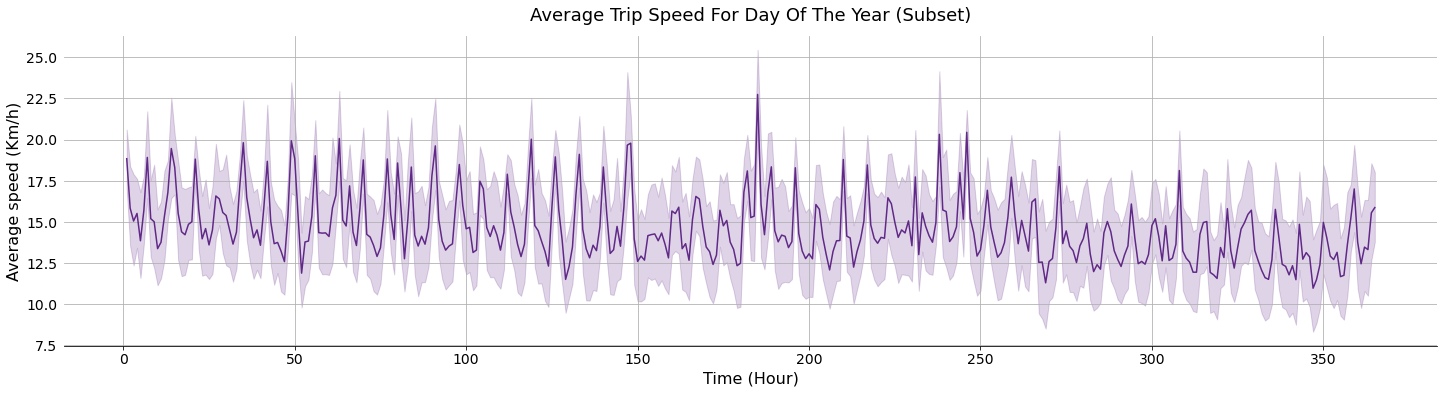

In [39]:
# Display a line plot of average daily trip speed for day of the year
plot_lineplot(
    hourly_pickup_avg_sub,
    x_var="pickup_yearday",
    y_var="trip_speed",
    xlabel="Time (Hour)",
    ylabel="Average speed (Km/h)",
    title="average trip speed for day of the year (subset)",
    color="#602887"
)

**Notes:** The line plot above shows the average daily travel speed for each day of the year. The average travel speed fluctuates throughout the year with repeated weekly peaks and drops. However, more variations can be observed during the first half of the year.

## 2.1.2 Primary Dataset: Spatio-Temporal Analysis
### Goal:
Detect and describe patterns, trends, and relationships among geospatial and temporal features in a subset (1%) of the 2018 NYC yellow cab trip dataset to identify variables that may impact traffic flow, and thus trip duration, in and around New York City.
### Code:

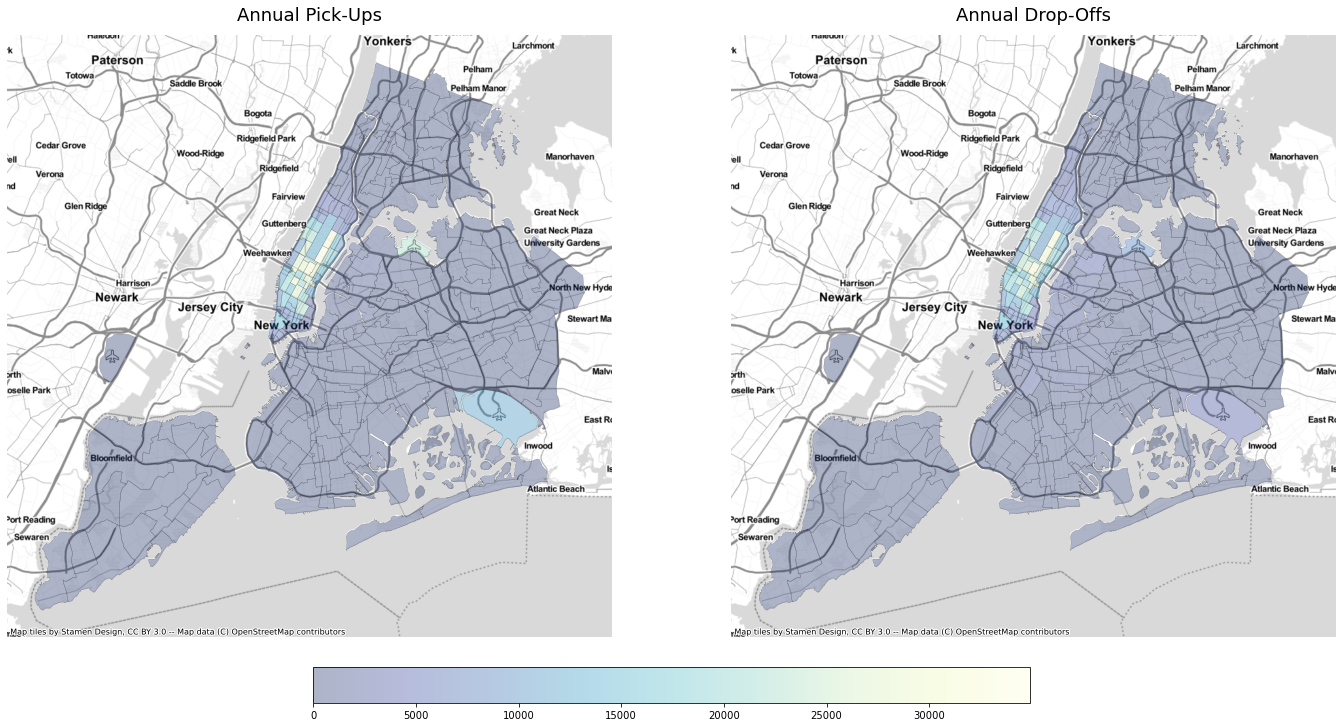

In [40]:
# Group taxi trips by pickup location
# Compute the number of trips
total_pickup_count = (
    train_df.groupby(["pickup_location_id"]).size().to_frame("pickup_all").reset_index()
).rename(columns={"pickup_location_id": "LocationID"})

# Group taxi trips by dropoff location
# Compute the number of trips
total_dropoff_count = (
    train_df.groupby(["dropoff_location_id"])
    .size()
    .to_frame("dropoff_all")
    .reset_index()
).rename(columns={"dropoff_location_id": "LocationID"})

# Merge the pickup location data with the zone data frame
zones_summary_df = pd.merge(zones_df, total_pickup_count, how="left", on="LocationID")

# Merge the dropoff location data with the zone data frame
zones_summary_df = pd.merge(
    zones_summary_df, total_dropoff_count, how="left", on="LocationID"
)

# Fill NaN with zeros to avoid missing locations on the map
zones_summary_df.fillna(0, inplace=True)

# Display heatmaps of the total number of trips by pickup and dropoff locations
plot_map(
    zones_summary_df,
    ["pickup_all", "dropoff_all"],
    ["Annual pick-ups", "Annual drop-offs"],
    ncols=2,
    legend=None,
    figsize=(20, 10),
)

**Notes:** The above heat maps show the number of annual taxi trips by location. There are no significant differences between arrival and departure locations, with the exception of JFK and LaGuardia airports. Thus, people arriving at airports are more likely to take a cab to New York City than to take one to the airport. In addition, most trips appears to be located made in midtown Manhattan, but drop-off locations are slightly more evenly distributed, including in suburban areas such as Queens, Bronx, and Brooklyn. Manhattan is the heart of New York City with its many stores, bars, and restaurants and is also one of the most densely populated boroughs. As a result, traffic jams are more likely to occur and special attention must be paid to travel times, which are more likely to vary considerably depending on a variety of factors, including holidays and weather conditions.

**Warnings:** The number of taxi trips is computed on 0.8% of the whole dataset.

In [41]:
# Group taxi trips by pickup borough
# Compute the number of trips
total_pickup_borough_count = (
    train_df.groupby(["pickup_borough_id"]).size().to_frame("pickup").reset_index()
).rename(columns={"pickup_borough_id": "borough"})

# Group taxi trips by dropoff borough
# Compute the number of trips
total_dropoff_borough_count = (
    train_df.groupby(["dropoff_borough_id"]).size().to_frame("dropoff").reset_index()
).rename(columns={"dropoff_borough_id": "borough"})

# Merge the pickup and dropoff borough data frame
total_trips_merged = pd.merge(
    total_pickup_borough_count, total_dropoff_borough_count, how="left"
)

# Replace numerical values by the name of the categories
total_trips_merged["borough"] = total_trips_merged["borough"].map(
    dict(zip(np.arange(0, len(boroughs)), boroughs))
)

# Display the whole data frame
total_trips_merged

borough  pickup  dropoff
0            EWR       1        4
1         Queens   42222    35793
2          Bronx     882     4907
3      Manhattan  771045   750113
4  Staten Island       7        5
5       Brooklyn   10497    33832

**Observation** A closer look at the annual number of pick-ups and drop-offs in each borough shows that the number of dropoffs is significantly higher than pick-ups in Brooklyn and the Bronx. As noted earlier, drop-off locations are more evenly distributed throughout New York State.

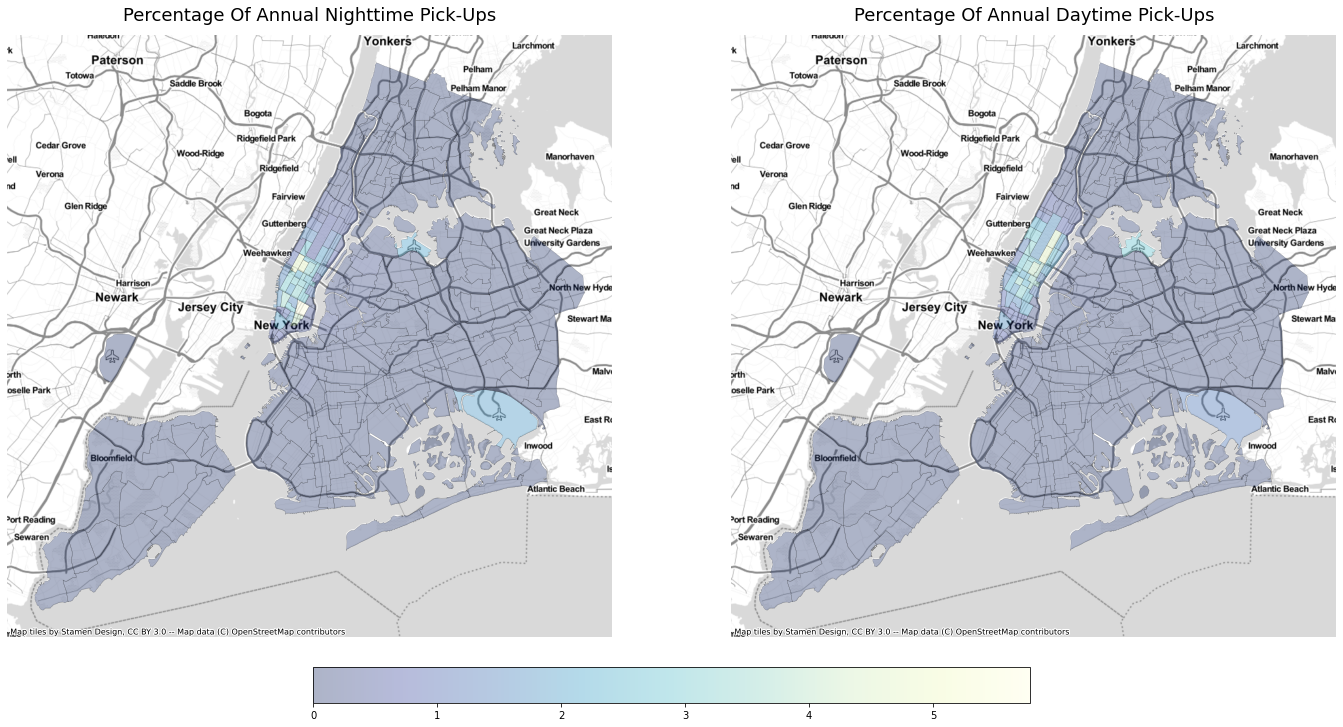

In [42]:
# Filter taxi trips by day time (night) and group them by pickup location
# Compute the number of trips
total_pickup_count_night = (
    train_df[train_df.pickup_hour_type == 0]
    .groupby(["pickup_location_id"])
    .size()
    .to_frame("pickup_all_night")
    .reset_index()
).rename(columns={"pickup_location_id": "LocationID"})

# Filter taxi trips by day time (night) and group them by pickup location
# Compute the number of trips
total_pickup_count_day = (
    train_df[train_df.pickup_hour_type == 1]
    .groupby(["pickup_location_id"])
    .size()
    .to_frame("pickup_all_day")
    .reset_index()
).rename(columns={"pickup_location_id": "LocationID"})

# Merge the pickup location (night) data with the zone data frame
zones_summary_df = pd.merge(
    zones_summary_df, total_pickup_count_night, how="left", on="LocationID"
)

# Merge the dropoff location (day) data with the zone data frame
zones_summary_df = pd.merge(
    zones_summary_df, total_pickup_count_day, how="left", on="LocationID"
)

# Fill NaN with zeros to avoid missing locations on the map
zones_summary_df.fillna(0, inplace=True)

# Convert pickup columns from counts to percentage of daily taxi trips
zones_summary_df[["pickup_all_night", "pickup_all_day"]] = zones_summary_df[
    ["pickup_all_night", "pickup_all_day"]
].transform(lambda x: np.divide(100 * x, x.sum()))

# Display heatmaps of the total number of trips by pickup and dropoff locations
plot_map(
    zones_summary_df,
    ["pickup_all_night", "pickup_all_day"],
    ["Percentage of annual nighttime pick-ups", "Percentage of annual daytime pick-ups"],
    ncols=2,
    legend=None,
    figsize=(20, 10),
)

**Notes:** The above heat maps show the percentage of annual taxi trips by location, during the day and night. At night, pick-ups are primarily located around Hell's kitchen, east-village and lower-east side, which are known for their lively nightlife. During the day, most pickups are in and around Central Park, specifically in the Upper East Side - the business district.

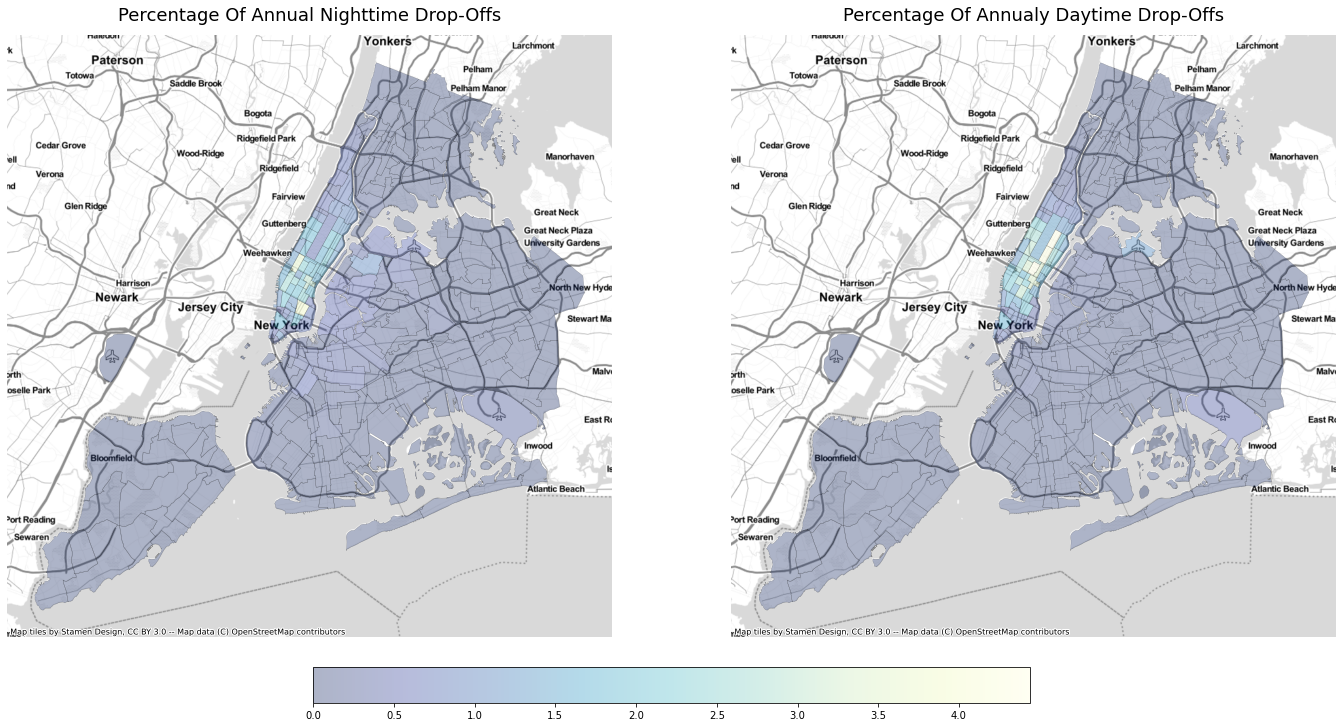

In [43]:
# Filter taxi trips by day time (night) and group them by dropoff location
# Compute the number of trips
total_dropoff_count_night = (
    train_df[train_df.pickup_hour_type == 0]
    .groupby(["dropoff_location_id"])
    .size()
    .to_frame("dropoff_all_night")
    .reset_index()
).rename(columns={"dropoff_location_id": "LocationID"})

# Filter taxi trips by day time (night) and group them by dropoff location
# Compute the number of trips
total_dropoff_count_day = (
    train_df[train_df.pickup_hour_type == 1]
    .groupby(["dropoff_location_id"])
    .size()
    .to_frame("dropoff_all_day")
    .reset_index()
).rename(columns={"dropoff_location_id": "LocationID"})

# Merge the dropoff location (night) data with the zone data frame
zones_summary_df = pd.merge(
    zones_summary_df, total_dropoff_count_night, how="left", on="LocationID"
)

# Merge the dropoff location (day) data with the zone data frame
zones_summary_df = pd.merge(
    zones_summary_df, total_dropoff_count_day, how="left", on="LocationID"
)

# Fill NaN with zeros to avoid missing locations on the map
zones_summary_df.fillna(0, inplace=True)

# Convert dropoff columns from counts to percentage of daily taxi trips
zones_summary_df[["dropoff_all_night", "dropoff_all_day"]] = zones_summary_df[
    ["dropoff_all_night", "dropoff_all_day"]
].transform(lambda x: np.divide(100 * x, x.sum()))

# Display heatmaps of the total number of trips by dropoff and dropoff locations
plot_map(
    zones_summary_df,
    ["dropoff_all_night", "dropoff_all_day"],
    ["Percentage of annual nighttime drop-offs", "Percentage of annualy daytime drop-offs"],
    ncols=2,
    legend=None,
    figsize=(20, 10),
)

**Notes:** The above heat maps show the percentage of annual taxi trips by location, during the day and night. Drop-offs show similar patterns to pick-ups. Southeast Manhattan is more busy at night, and central Manhattan during the day. In addition, suburban areas, including Queens, the Bronx, and Brooklyn, account for a large fraction of nighttime drop-offs. Below we will examine the change in the annual percentage of taxi rides in each borough and for each day of the week to answer our previous questions: do pick-up and drop-off locations change significantly over the week? Is the number of taxi trips directly link to trafic congestion/fluidity and trip duration?

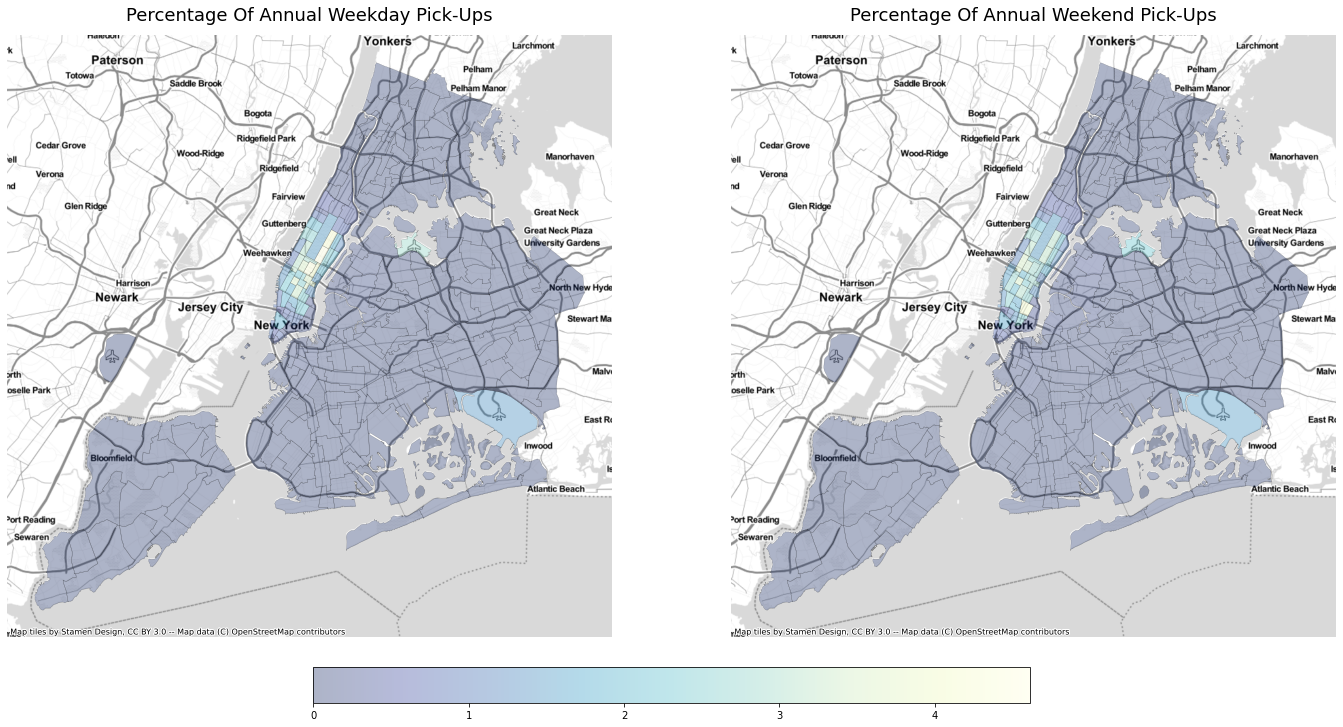

In [44]:
# Group taxi trips by pickup location and type of day
# Compute the number of trips
weekly_pickup_count = (
    train_df.groupby(["pickup_location_id", "pickup_weekday_type"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Add the pickup prefix to the weekdays and weekends
weekly_pickup_columns = ["pickup_" + w.lower().strip() for w in ["week", "weekend"]]

# Map numerical values to week days
weekly_pickup_count["pickup_weekday_type"] = weekly_pickup_count["pickup_weekday_type"].map(
  dict(zip([0,1], weekly_pickup_columns))
)

# Pivot the daily pickup data frame on the pickup weekday column
weekly_pickup_count = weekly_pickup_count.pivot(
    index="pickup_location_id", columns="pickup_weekday_type", values="count"
).reset_index()

# Rename the id column of the daily pickup data frame
weekly_pickup_count = weekly_pickup_count.rename(
    columns={"pickup_location_id": "LocationID"}
)

# Merge the daily pickup data frame with the zone summary
zones_summary_df = pd.merge(
    zones_summary_df, weekly_pickup_count, how="left", on="LocationID"
)

# Fill NaN with zeros to avoid missing locations on the map
zones_summary_df.fillna(0, inplace=True)

# Convert pickup columns from counts to percentage of daily taxi trips
zones_summary_df[weekly_pickup_columns] = zones_summary_df[
    weekly_pickup_columns
].transform(lambda x: np.divide(100 * x, x.sum()))

# Display heatmaps of the percentage of daily trips by pickup location
plot_map(
    zones_summary_df,
    ["pickup_week", "pickup_weekend"],
    ["Percentage of annual weekday pick-ups", "Percentage of annual weekend pick-ups"],
    ncols=2,
    legend=None,
    figsize=(20, 10),
)


**Notes:** The heat maps above show the percentage of annual taxi trips by location and for weekdays and weekends. Midtown Manhattan is more heavily traveled during the week and the southeast and suburbs during the weekend. This result is consistent with previous observations.

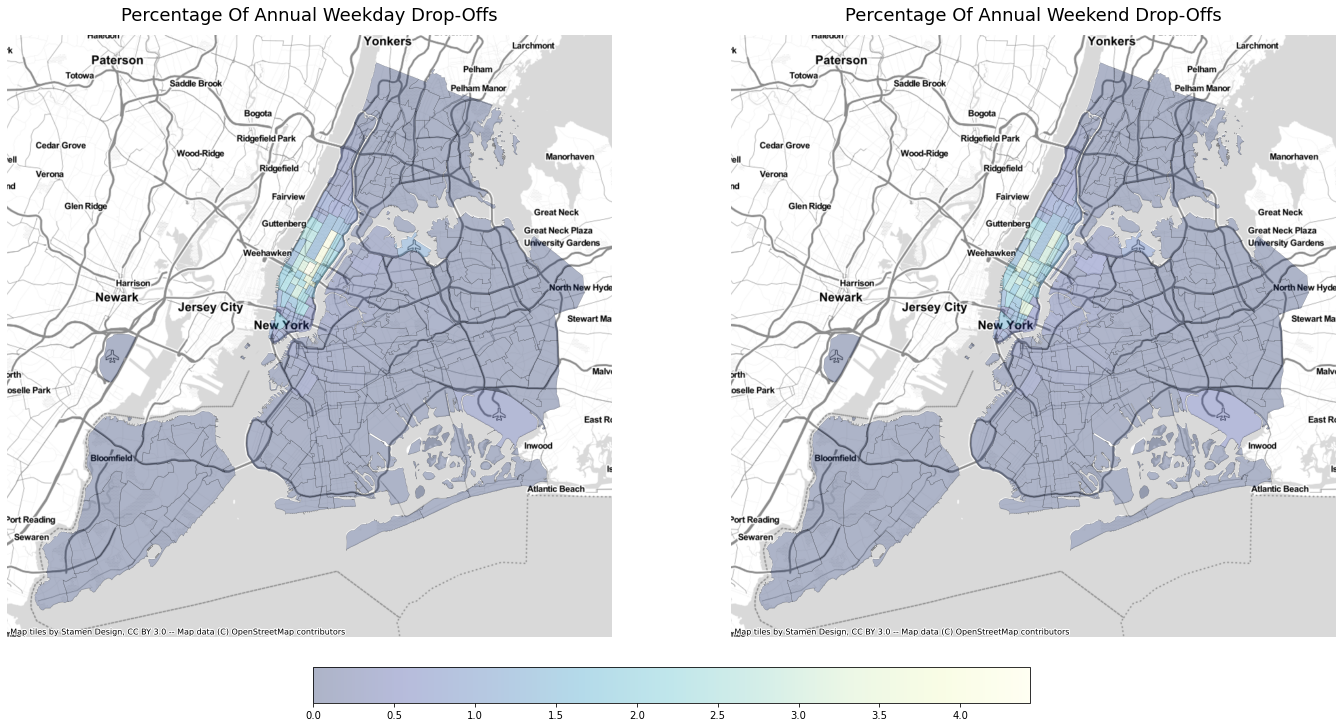

In [45]:
# Group taxi trips by dropoff location and type of day
# Compute the number of trips
weekly_dropoff_count = (
    train_df.groupby(["dropoff_location_id", "pickup_weekday_type"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Add the dropoff prefix to the weekdays and weekends
weekly_dropoff_columns = ["dropoff_" + w.lower().strip() for w in ["week", "weekend"]]

# Map numerical values to week days
weekly_dropoff_count["pickup_weekday_type"] = weekly_dropoff_count["pickup_weekday_type"].map(
  dict(zip([0,1], weekly_dropoff_columns))
)

# Pivot the daily dropoff data frame on the dropoff weekday column
weekly_dropoff_count = weekly_dropoff_count.pivot(
    index="dropoff_location_id", columns="pickup_weekday_type", values="count"
).reset_index()

# Rename the id column of the daily dropoff data frame
weekly_dropoff_count = weekly_dropoff_count.rename(
    columns={"dropoff_location_id": "LocationID"}
)

# Merge the daily dropoff data frame with the zone summary
zones_summary_df = pd.merge(
    zones_summary_df, weekly_dropoff_count, how="left", on="LocationID"
)

# Fill NaN with zeros to avoid missing locations on the map
zones_summary_df.fillna(0, inplace=True)

# Convert dropoff columns from counts to percentage of daily taxi trips
zones_summary_df[weekly_dropoff_columns] = zones_summary_df[
    weekly_dropoff_columns
].transform(lambda x: np.divide(100 * x, x.sum()))

# Display heatmaps of the percentage of daily trips by dropoff location
plot_map(
    zones_summary_df,
    ["dropoff_week", "dropoff_weekend"],
    ["Percentage of annual weekday drop-offs", "Percentage of annual weekend drop-offs"],
    ncols=2,
    legend=None,
    figsize=(20, 10),
)

**Notes:** The heat maps above show the percentage of annual taxi trips by location and for weekdays and weekends. Similarily to the previous observations, Midtown Manhattan is more heavily traveled during the week and the southeast and suburbs during the weekend. Therefore pick-up and drop-off locations do not change significantly during the week, but between weekdays and weekends. However, it is still difficult to tell whether the reduction in the number of taxi trips is linked to shorter travel time. Let's first analyze the distance, duration and speed for trips that take place in the same district.

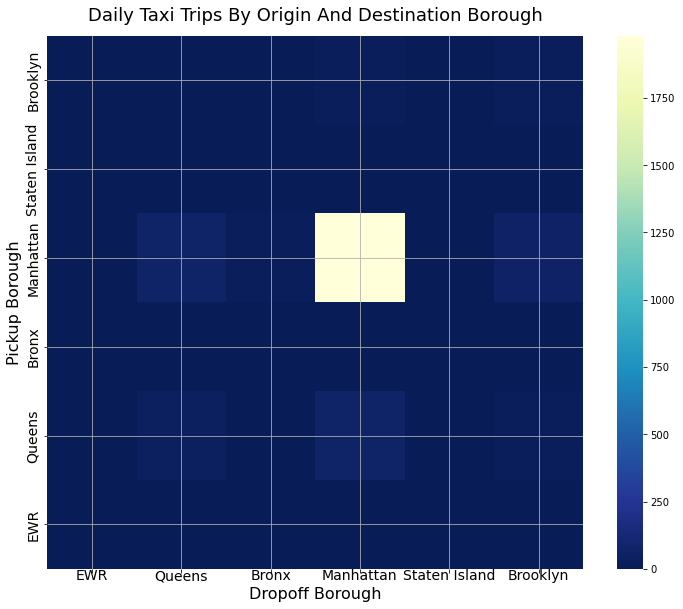

In [46]:
# Group taxi trips by pickup year-day, pickup borough, and dropff borough
# Compute the number of daily trip
pickup_count_borough = (
    train_df.groupby(["pickup_yearday", "pickup_borough_id", "dropoff_borough_id"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Group taxi trips by pickup borough, and dropff borough
# Compute average number of daily trip
pickup_mean_borough = (
    pickup_count_borough.groupby(["pickup_borough_id", "dropoff_borough_id"])
    .agg(mean=("count", "mean"))
    .reset_index()
)

# Pivot the data frame on the droppoff borough column
pickup_count_borough_pvt = pickup_mean_borough.pivot(
    index="pickup_borough_id", columns="dropoff_borough_id", values="mean"
)

# Fill NaN with zeros to avoid missing locations on the map
pickup_count_borough_pvt.fillna(0, inplace=True)

# Display a heatmap of the average number of daily taxi trips 
plot_heatmap(
    pickup_count_borough_pvt,
    xticks=boroughs,
    yticks=boroughs,
    xlabel="Dropoff Borough",
    ylabel="Pickup Borough",
    title="daily taxi trips by origin and destination borough",
    figsize=(10, 8)
)

**Notes:** The heat map above shows the average number of daily taxi trips by origin and destination borough. The majority of the trips are within the same borough and most of them start and end in Manhattan, which isn't surprising as yellow taxi operate mostly in Manhattan. As noted above, another significant portion of trips start in Manhattan and end in Queens or Brooklyn. Below we will have a closer look at the amount of trips happening within the same or to another borough.

**Warnings:** The average number of taxi trips is computed on 0.8% of the whole dataset.

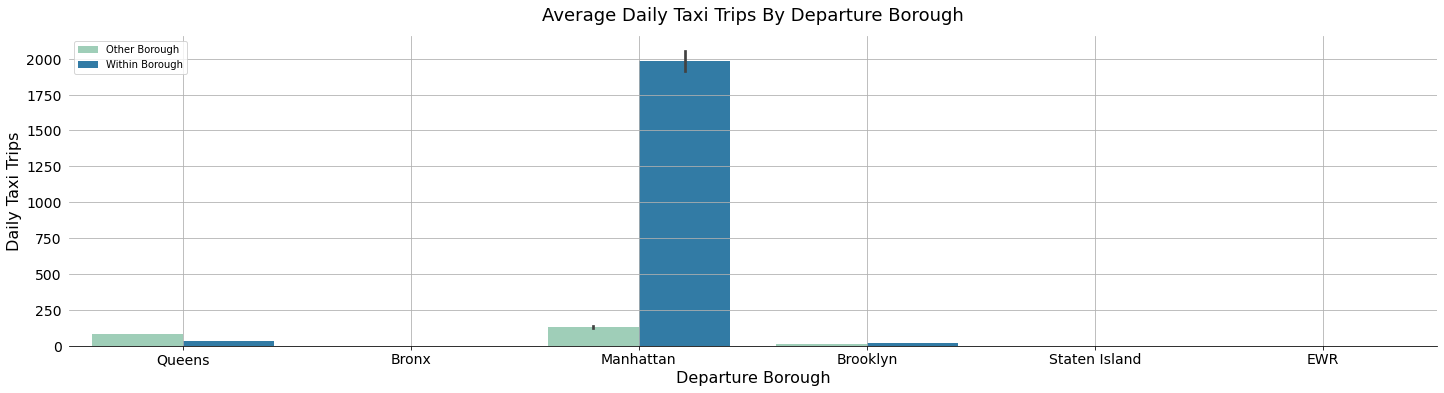

In [47]:
# Group taxi trips by pickup year-day, pickup borough, and within borough indicator
# Compute the number of daily trip
pickup_count_boro_twb = (
    train_df.groupby(["pickup_yearday", "pickup_borough_id", "trip_within_borough"])
    .size()
    .to_frame("count")
    .reset_index()
)

# Replace zero counts with NaN to prevent lowering the average.
pickup_count_boro_twb["count"].replace(0, np.nan, inplace=True)

# Replace numerical values by the name of the categories
pickup_count_boro_twb["trip_within_borough"] = pickup_count_boro_twb[
    "trip_within_borough"
].map(
    dict(
        zip(
            np.arange(0, 2),
            ["Other Borough", "Within Borough"],
        )
    )
)

# Replace numerical values by the name of the categories
pickup_count_boro_twb["pickup_borough_id"] = pickup_count_boro_twb[
    "pickup_borough_id"
].map(
    dict(
        zip(
            np.arange(0, 7),
            boroughs,
        )
    )
)

# Display a barplot of the average number of daily trips by departure borough
plot_barplot(
    pickup_count_boro_twb,
    x_var="pickup_borough_id",
    y_var="count",
    labels="trip_within_borough",
    xlabel="Departure Borough",
    ylabel="Daily Taxi Trips",
    title="average daily taxi trips by departure borough"
)

**Notes:** The histogram above shows the average daily taxi trips by departure borough and within the same borough or to another borough. As noted above, most trips are within the same borough and specifically in Manhattan. 

**Warnings:** Taxi trips starting the Bronx, Staten Island, and EWR are very infrequent and later results will have to be interpreted with caution.

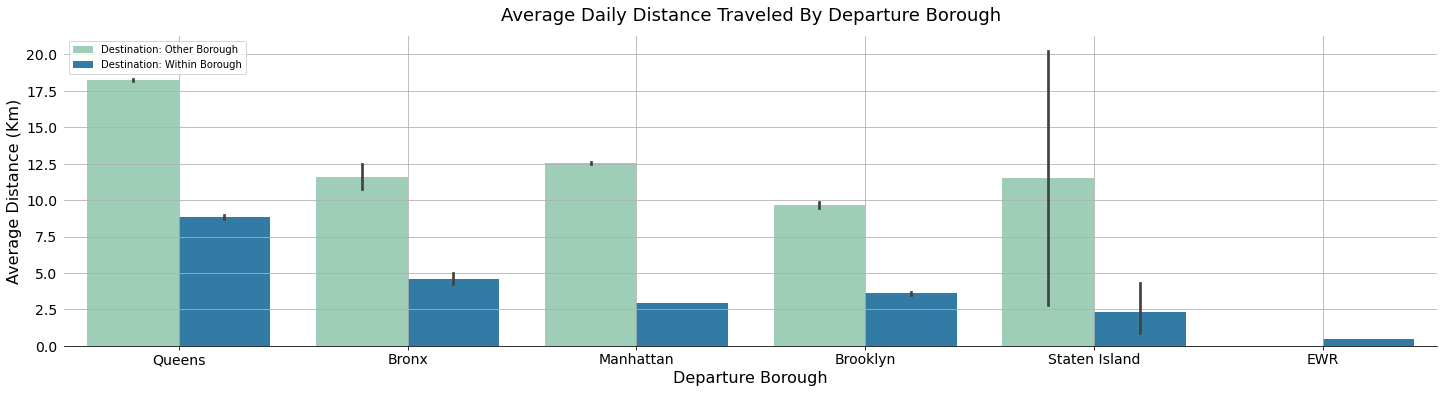

In [48]:
# Group taxi trips by pickup year-day, pickup borough, dropff borough, and within borough trip
# Compute the mean of trip distances and durations
pickup_avg_boro = (
    train_df.groupby(["pickup_yearday", "pickup_borough_id", "trip_within_borough"])
    .agg({"trip_distance": np.mean, "trip_duration": np.mean})
    .reset_index()
)

# Compute the average trip speed
pickup_avg_boro["trip_speed"] = np.divide(
    pickup_avg_boro["trip_distance"], np.divide(pickup_avg_boro["trip_duration"], 60)
)

# Replace numerical values by the name of the categories
pickup_avg_boro["trip_within_borough"] = pickup_avg_boro["trip_within_borough"].map(
    dict(
        zip(
            np.arange(0, 2),
            ["Destination: Other Borough", "Destination: Within Borough"],
        )
    )
)

# Replace numerical values by the name of the categories
pickup_avg_boro["pickup_borough_id"] = pickup_avg_boro["pickup_borough_id"].map(
    dict(
        zip(
            np.arange(0, 7),
            boroughs,
        )
    )
)

# Display a barplot of the average daily distance traveled by departure borough
plot_barplot(
    pickup_avg_boro,
    x_var="pickup_borough_id",
    y_var="trip_distance",
    labels="trip_within_borough",
    xlabel="Departure Borough",
    ylabel="Average Distance (Km)",
    title="average daily distance traveled by departure borough"
)

**Notes:** The barplot above shows the average daily distance travelled by depature borough and within the same borough or to another borough. The average distance traveled is significantly lower for trips within the same borough than to another borough. In addition, excluding Staten Island and EWR, the travel distance is the lowest for Manhattan.

**Warnings:** The average trip distance computed for the Bronx, Staten Island, and EWR should be interpreted with caution as yellow taxi trips starting in these boroughs are very infrequent.

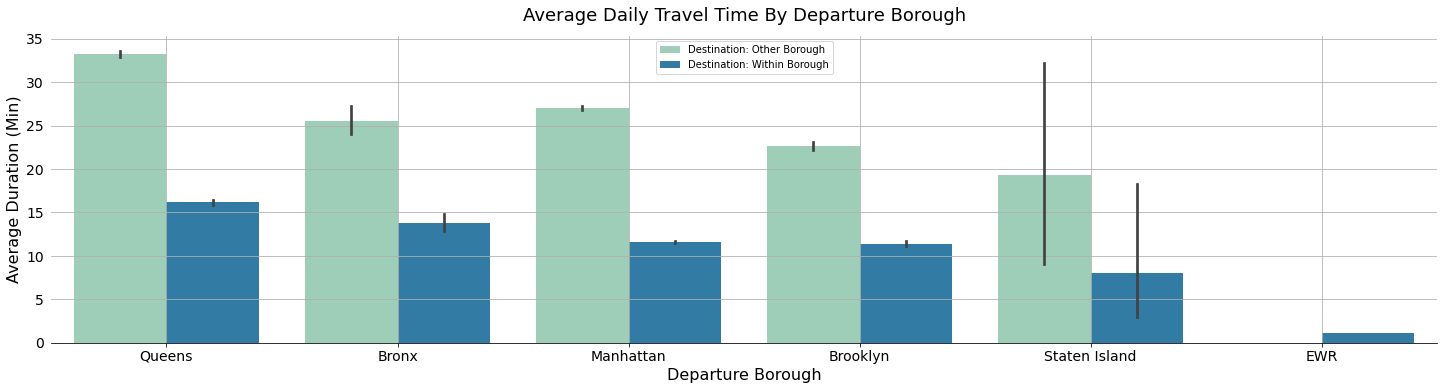

In [49]:
# Display a barplot of the average daily travel time by departure borough
plot_barplot(
    pickup_avg_boro,
    x_var="pickup_borough_id",
    y_var="trip_duration",
    labels="trip_within_borough",
    xlabel="Departure Borough",
    ylabel="Average Duration (Min)",
    title="average daily travel time by departure borough"
)

**Notes:** The barplot above shows the average daily travel duration by depature borough and within the same borough or to another borough. The average travel duration is significantly lower for trips within the same borough than to another borough, which may be expected since the distance traveled is also lower. However, travel time in Manhattan is comparable to that of Brooklyn for trips within the same borough.

**Warnings:** The average trip duration computed for the Bronx, Staten Island, and EWR should be interpreted with caution as yellow taxi trips starting in these boroughs are very infrequent.

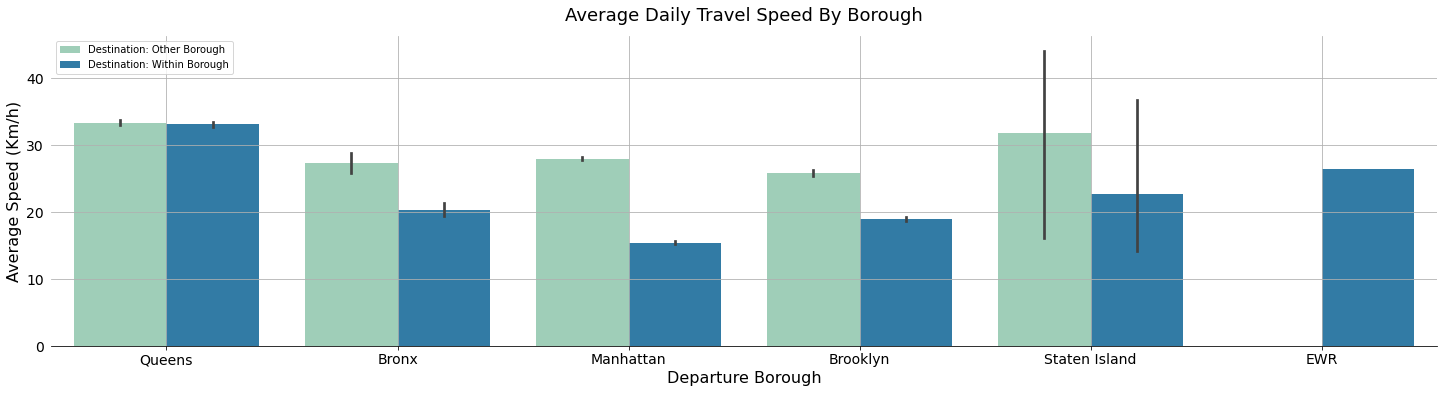

In [50]:
# Display a barplot of the average daily travel speed by departure borough
plot_barplot(
    pickup_avg_boro,
    x_var="pickup_borough_id",
    y_var="trip_speed",
    labels="trip_within_borough",
    xlabel="Departure Borough",
    ylabel="Average Speed (Km/h)",
    title="average daily travel speed by borough"
)

**Notes:** The barplot above shows the average daily travel speed by departure borough, within the same borough or to another borough. The difference in travel speed between trips within a borough and to another borough is not as significant as the difference in average travel distance and duration. Manhattan, with its high population density and numerous intersections, appears to be one of the boroughs most strongly affected by traffic density, since the travel speed within this borough is the lowest. Below we will take a look at the correlation between the number of daily taxi trips and the average trip duration.

**Warnings:** The average trip speed computed for the Bronx, Staten Island, and EWR should be interpreted with caution as yellow taxi trips starting in these boroughs are very infrequent.

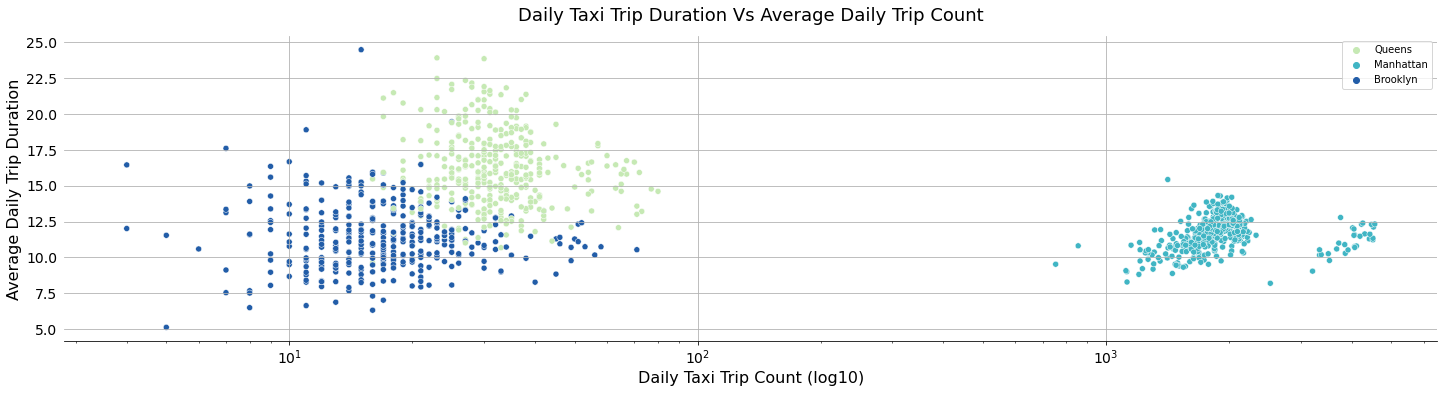

In [51]:
# Get a subset of the train data frame where trips are within the same borough and only Queens, Manhattan, and Brooklyn are selected
filtered_corr_df = train_df[
    (train_df.trip_within_borough == 1)
    & (train_df["pickup_borough_id"].isin([1, 3, 5]))
]

# Group taxi trips by pickup year-day, and pickup borough
# Compute the number of daily taxi trips
pickup_count_boro_corr = (
    filtered_corr_df.groupby(["pickup_yearday", "pickup_borough_id"])
    .size()
    .to_frame("trip_count")
    .reset_index()
)

# Group taxi trips by pickup year-day, and pickup borough
# Compute the mean of trip duration
pickup_avg_boro_corr = (
    filtered_corr_df.groupby(["pickup_yearday", "pickup_borough_id"])
    .agg({"trip_duration": np.mean})
    .reset_index()
)

# Merge the two data frames into a new one
pickup_boro_corr = pd.merge(pickup_count_boro_corr, pickup_avg_boro_corr, how="left")

# Replace numerical values by the name of the categories
pickup_boro_corr["pickup_borough_id"] = pickup_boro_corr["pickup_borough_id"].map(
    dict(
        zip(
            np.arange(0, 7),
            boroughs,
        )
    )
)

# Display a scatter plot of daily taxi trip duration vs the average daily trip count
plot_scatterplot(
    pickup_boro_corr,
    x_var="trip_count",
    y_var="trip_duration",
    labels="pickup_borough_id",
    xlabel="Daily Taxi Trip Count (log10)",
    ylabel="Average Daily Trip Duration",
    title="daily taxi trip duration vs average daily trip count"
)

**Notes:** The scatter plot above shows the average daily trip length as a function of the number of daily taxi trips. Different patterns are observed for different borough. For Queens, there appears to be a negative correlation between the number of daily rides and their duration, while the correlation appears to be positive for Manhattan.

**Warnings:** data for the Bronx, Staten Island, and EWR were not included in this analysis as yellow taxi trips starting in these boroughs are very infrequent and may cause intepretation issues.

In [52]:
# Calculate Pearson correlation coefficient between the number of trips and trip duration for the three selected boroughs.
pickup_boro_corr["trip_count"].corr(pickup_boro_corr["trip_duration"])

-0.2946718977115635

**Notes:** If we consider New York state as a single entity, there is a negative correlation between the number of daily trips and their duration.

In [53]:
# Calculate Pearson correlation coefficient between the number of trips and trip duration for Manhattan
pickup_boro_corr.loc[
    pickup_boro_corr["pickup_borough_id"] == "Manhattan", "trip_count"
].corr(pickup_boro_corr["trip_duration"])

0.10582361525680346

**Notes:** There is a weak positive correlation between the number of daily trips and their duration for Manhattan. In this case, the number of daily trips could be used as an indicator of traffic density. However, let's bear in mind that numerous factors affect traffic density.

In [54]:
# Calculate Pearson correlation coefficient between the number of trips and trip duration for Queens
pickup_boro_corr.loc[
    pickup_boro_corr["pickup_borough_id"] == "Queens", "trip_count"
].corr(pickup_boro_corr["trip_duration"])

-0.13072589034990323

**Notes:** There is a low negative correlation between the number of daily trips and their duration for Queens. This weak negative correlation cannot be easily explained and further investigations should be conducted.

In [55]:
# Calculate Pearson correlation coefficient between the number of trips and trip duration for Brooklyn
pickup_boro_corr.loc[
    pickup_boro_corr["pickup_borough_id"] == "Brooklyn", "trip_count"
].corr(pickup_boro_corr["trip_duration"])

-0.030611815438412095

**Notes:** Finally, there is no correlation between the number of daily trips and their duration for Brooklyn. The impact of an increase or decrease in daily taxi trips on travel time is more complex than expected and should be studied separately for each borough. Below, we will take a closer look at tolls and their impact on travel distance, duration, and speed.

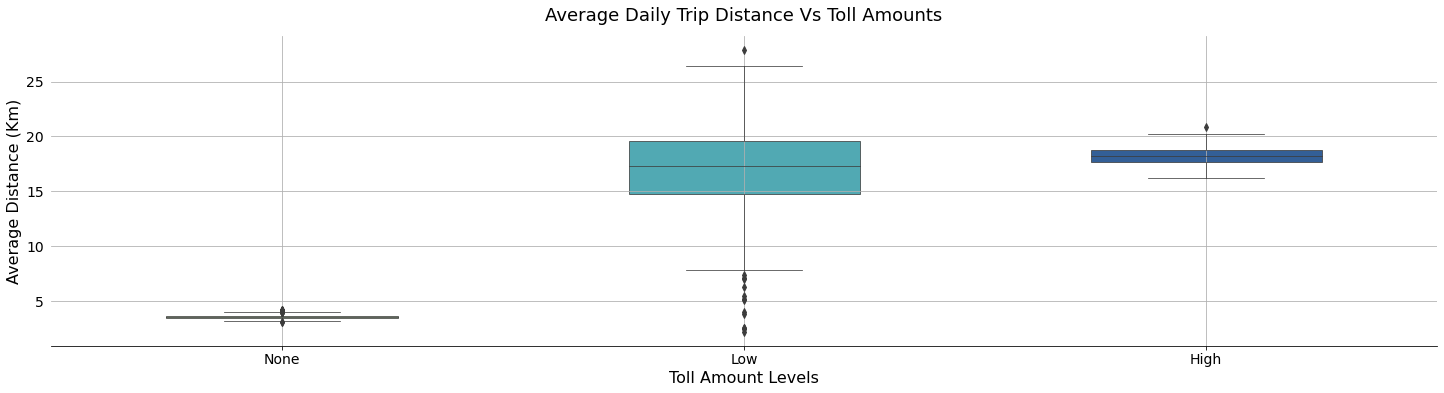

In [56]:
# Group taxi trips by pickup year-day and toll amounts
# Compute the mean of trip distances and durations
pickup_avg_toll = (
    train_df.groupby(["pickup_yearday", "tolls_amount_lvl"])
    .agg({"trip_distance": np.mean, "trip_duration": np.mean})
    .reset_index()
)

# Compute the average trip speed
pickup_avg_toll["trip_speed"] = np.divide(
    pickup_avg_toll["trip_distance"], np.divide(pickup_avg_toll["trip_duration"], 60)
)

# Replace numerical values by the name of the categories
pickup_avg_toll["tolls_amount_lvl"] = pickup_avg_toll["tolls_amount_lvl"].map(
    dict(zip(np.arange(0, 3), ["None", "Low", "High"]))
)

# Display a boxplot of average daily trip distance vs toll amounts 
plot_boxplot(
    pickup_avg_toll,
    x_var="tolls_amount_lvl",
    y_var="trip_distance",
    xlabel="Toll Amount Levels",
    ylabel="Average Distance (Km)",
    title="average daily trip distance vs toll amounts"
)

**Notes:** The boxplots above show the average daily distance traveled as a function of the amount of toll paid. The average distance traveled is three to five time greater when the trip passes through a tollbooth. However, there is no snignificant difference between high and low toll prices. Tollbooths are typically located before bridges, tunnels and on highways in the New York metropolitan area. Paying at a tollbooth usually implies a longer distance to travel to the destination. These facilities are also a major cause of traffic congestion because cars must stop to pay at the booth. However, the booths have recently been replaced by a new [automated systems](https://www.localsyr.com/news/local-news/construction-to-remove-toll-booths-along-nys-thruway-resumes/).

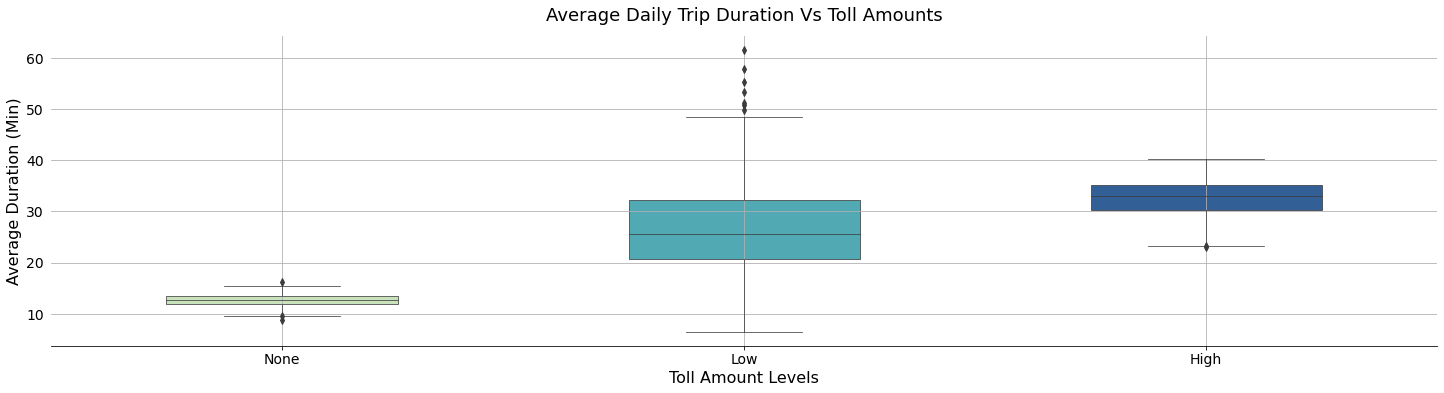

In [57]:
# Display a boxplot of average daily trip duration vs toll amounts 
plot_boxplot(
    pickup_avg_toll,
    x_var="tolls_amount_lvl",
    y_var="trip_duration",
    xlabel="Toll Amount Levels",
    ylabel="Average Duration (Min)",
    title="average daily trip duration vs toll amounts"
)

**Notes:** The boxplots above show the average daily travel time as a function of the amount of toll paid. The average travel time is two to three times higher when the trip passes through a toll booth. There is also a significant difference between high and low toll prices. The higher the price, the longer the travel time. As the price [varies](https://tollguru.com/toll-wiki/toll-rates-new-york-bridges-tunnels), different prices may give us an approximate origin and destination of the trip.

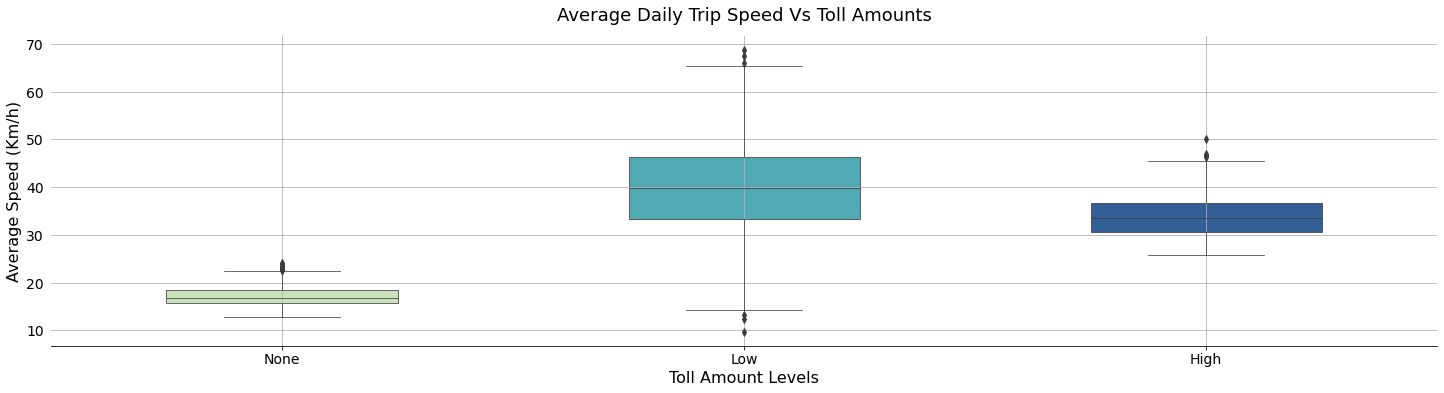

In [58]:
# Display a boxplot of average daily trip speed vs toll amounts 
plot_boxplot(
    pickup_avg_toll,
    x_var="tolls_amount_lvl",
    y_var="trip_speed",
    xlabel="Toll Amount Levels",
    ylabel="Average Speed (Km/h)",
    title="average daily trip speed vs toll amounts"
)

**Note:** The graphs above show the average daily travel speed as a function of the amount of toll paid. The average travel speed is also two to three times higher when the trip passes through a tollbooth. This could mean that most trips passing through a toll occur in low-density areas or are going from a high-density area to a low-density area and vice versa. Road infrastructure may also play an important role in this respect, as speed limit increases on highways. In addition, there is also a marginal difference between high and low toll prices. Trips with high toll prices have lower travel speeds than those with low toll prices. This could indicate that the cab passed through a high traffic density area or that traffic was slowed down at some point due to other circumstances.

***